In [43]:
#importing required packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import defaultdict
from scipy.stats import pearsonr, chi2_contingency
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import datetime
import time
import pickle
import os
from sklearn import naive_bayes
from sklearn import discriminant_analysis
import seaborn as sns

In [3]:
#reading in our data
accepted_df = pd.read_csv('accepted_2007_to_2018Q4.csv', sep = ',')

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#creating function to quickly get an idea of values that comprise feature 
def variable_expl(variable):
    print(accepted_df[variable].value_counts())
    print(' ')
    print('Number of NA\'s is:', accepted_df[variable].isna().sum())
    print('Number of unique values is:', accepted_df[variable].nunique())
    if accepted_df[variable].dtype == 'float64' or accepted_df[variable].dtype == 'int64':
        print('Mean is:', np.mean(accepted_df[variable]))
        print('Std.Dev is:', np.std(accepted_df[variable]))
    else:
        return False

In [5]:
#creating function to return correlation value between two features 
def corr_value(variable1, variable2):
    print(accepted_df[variable1].corr(accepted_df[variable2]))

In [6]:
#creating a function that can print full series values in Jupyter notebook
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [7]:
#creating a function to return correlation values between numeric variables
#num_feat2 needs to be instantiated in order for correlation to run
from collections import defaultdict

        
def correlation(variable):
    dict1 = defaultdict(int)
    for x in accepted_df[num_feat2].columns.values:
        corr1 = accepted_df[x].corr(accepted_df[variable])
        dict1[x] = abs(corr1)
    return sorted(dict1.items(), key = lambda x: x[1], reverse = True)

In [8]:
#creating month_dict to map str month values to int
month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [9]:
#dropping observations with NA's for loan status
accepted_df = accepted_df.dropna(subset = ['loan_status'])

#creates issue_d_year and issue_d_month variables that will be later used to filter the dataframe 

def date_transformation(df):
    df[['earliest_cr_line_month','earliest_cr_line_year']] = df['earliest_cr_line'].str.split('-', expand = True)
    df['earliest_cr_line_year'] = df['earliest_cr_line_year'].fillna('2019')
    df['earliest_cr_line_month'] = df['earliest_cr_line_month'].fillna('Jun')
    df[['issue_d_month','issue_d_year']] = df['issue_d'].str.split('-', expand = True)
    df.issue_d_year = df.issue_d_year.astype('int64')
    
    #mapping string months to num months for datetime conversion
    month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    df['issue_d_month_num'] = df['issue_d_month'][:] 
    df['issue_d_month_num'] = df['issue_d_month_num'].replace(month_dict)
    df['issue_d_date'] = str('15/') + df['issue_d_month_num'].astype(str) + '/' + df['issue_d_year'].astype(str)
    df['issue_d_date'] = pd.to_datetime(df['issue_d_date'], infer_datetime_format=True)
    df.drop(['issue_d_month_num'], axis = 1, inplace = True)
    df['Year'] = pd.DatetimeIndex(df['issue_d_date']).year

    return df.shape

date_transformation(accepted_df)

(2260668, 157)

In [10]:
#selecting only 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019 data
accepted_df = accepted_df[accepted_df['issue_d_year'].isin([2012,2013,2014,2015,2016,2017,2018,2019])]

#IMPUTATION

#fillmean values 
fillmean = ['annual_inc','delinq_amnt','acc_now_delinq','delinq_2yrs','dti','revol_util','inq_last_6mths',
           'open_acc','pub_rec','open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il',
           'il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi',
           'total_cu_tl','inq_last_12m','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util',
           'mo_sin_old_il_acct','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_recent_bc',
           'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_bc_sats','num_bc_tl','num_il_tl',
           'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd',
           'num_tl_90g_dpd_24m','num_tl_op_past_12m','percent_bc_gt_75','tot_hi_cred_lim','total_bc_limit',
           'total_il_high_credit_limit']


#missing values here likely mean absence of the feature for that observation. 
fillzero = ['open_acc','pub_rec','inq_last_6mths','tax_liens','collections_12_mths_ex_med',
           'chargeoff_within_12_mths','pub_rec_bankruptcies','emp_length','tot_coll_amt']


def fillvars(accepted_df):
    for x in fillmean:
        try:
            accepted_df[x] = accepted_df[x].fillna(accepted_df[x].mean())
        except:
            continue
    for d in fillzero:
        try:
            accepted_df[d] = accepted_df[d].fillna(0)
        except:
            continue
fillvars(accepted_df)
    

In [11]:
#dropping irrelevant or missing data features from the start

#dropping certain variables from the get-go in order to reduce processing time during multicollinearity analysis
accepted_df = accepted_df.drop(['member_id','id','funded_amnt_inv','url','desc'], axis = 1)
#looking at variables with highest NA counts
accepted_df_nas = (accepted_df.isna().sum()/accepted_df.shape[0]).reset_index()
accepted_df_nas.columns = ['Feature','Percent_Missing']
accepted_df_nas = accepted_df_nas.sort_values(by = 'Percent_Missing')
#getting index list of variables wiht > 50% missing values 
index1 = list(accepted_df_nas[accepted_df_nas['Percent_Missing'] > 0.5].index)
#dropping the columns that have missing values > 0.5
accepted_df.drop(accepted_df.columns[index1], axis = 1, inplace = True)
#since policy_code has only one value, drop this column as well
accepted_df = accepted_df.drop(['policy_code'], axis = 1)
#zip_code variable has last two digits of zip_code missing, so we can safely drop this one 
accepted_df = accepted_df.drop(['zip_code'], axis = 1)
#drop last_payment_d variable because this variable would not be accessible to investors and would introduce data leakage
accepted_df.drop(['last_pymnt_d','collection_recovery_fee','recoveries'], axis = 1, inplace = True)
#drop last_fico_range_low because of high correlation with last_fico_range_high
accepted_df.drop(['last_fico_range_low'], axis = 1, inplace = True)
#cleaning categorical variables 
#term should be converted to numeric
accepted_df['term'] = accepted_df['term'].replace({' 36 months':36,' 60 months':60})
#85% of last_credit_pull_d values are Mar-2019, so drop
accepted_df.drop(['last_credit_pull_d'], axis = 1, inplace = True)
#title and purpose variables are quasi-identical, so drop one
accepted_df.drop(['title'], axis = 1, inplace = True)
#creating a new variable to capture number of years of oldest credit line, defined as issue_d - earliest_cr_line

In [12]:
accepted_df['earliest_cr_line_month_num'] = accepted_df['earliest_cr_line_month'][:] 
accepted_df['earliest_cr_line_month_num'] = accepted_df['earliest_cr_line_month_num'].replace(month_dict)
accepted_df['earliest_cr_line_date'] = str('15/') + accepted_df['earliest_cr_line_month_num'].astype(str) + '/' + accepted_df['earliest_cr_line_year'].astype(str)
accepted_df.drop(['earliest_cr_line_month_num'], axis = 1, inplace = True)
accepted_df['earliest_cr_line_date'] = pd.to_datetime(accepted_df['earliest_cr_line_date'], infer_datetime_format=True)
#creating new variable capturing amount of years of oldest credit line 
accepted_df['earliest_credit_line_years'] = accepted_df['issue_d_date'] - accepted_df['earliest_cr_line_date'] 
#dropping debt_settlement_flag because this would introduce data leakage into the dataset
#dropping 'earliest_cr_line_month','earliest_cr_line_year','issue_d_month' because these are now captured in earliest_credit_line_yearsa nd issue_d_date
accepted_df.drop(['debt_settlement_flag', 'earliest_cr_line_month','earliest_cr_line_year','issue_d_month'], axis = 1, inplace = True)
#dropping earliest_cr_line
accepted_df.drop(['earliest_cr_line'], axis = 1, inplace = True)
#dropping emp_title because mapping to general categories i.e. Director or President 
# would most likely be highly correlated with income and would be very computationally/time expensive
accepted_df.drop(['emp_title'],axis = 1, inplace = True)
#dropping issue_d_year because year already captured in issue_d_date
accepted_df.drop(['issue_d_year'],axis = 1, inplace = True)
#dropping issue_d because year already captured in issue_d_date
accepted_df.drop(['issue_d'],axis = 1, inplace = True)
#mapping 10+ years to 11 years and <1 years to 0 years in emp_length and converting this to a float
accepted_df['emp_length'] = accepted_df['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
accepted_df['emp_length'] = accepted_df['emp_length'].str.extract('(\d+)').astype('float')
#replacing values in application_type_variable
accepted_df['application_type'] = accepted_df['application_type'].replace({'Individual':'Ind','Joint App':'Joint'}) 
#dropping pymnt_plan and hardship_flag because keeping these would constitute data leakage 
accepted_df.drop(['pymnt_plan','hardship_flag'],axis = 1, inplace = True)
#mapping our dependent variable loan_status to 0/1 values
accepted_df['loan_status'] = accepted_df['loan_status'].isin(['Fully Paid','Current','In Grace Period','Does not meet the credit policy. Status:Fully Paid']).astype('int64')

In [13]:
#exploratory data analysis of emp_length vs loan_status

eda1 = accepted_df.groupby(['addr_state','emp_length'])['loan_status'].mean().to_frame().reset_index()
eda1['loan_status'] = 1 - eda1['loan_status']
eda1['above_average'] = np.where(eda1['loan_status'] > np.mean(eda1['loan_status']), 1, 0)
eda1.loc[eda1['emp_length'] == 11, 'emp_length'] = 10
eda1['emp_length'].value_counts()

1.0     51
0.0     51
10.0    50
9.0     50
8.0     50
7.0     50
6.0     50
5.0     50
4.0     50
3.0     50
2.0     50
Name: emp_length, dtype: int64

In [158]:
#pickling this emp_length groupby dataframe
with open('eda1.pickle','wb') as eda1_file:
     pickle.dump(eda1, eda1_file)

In [20]:
#creating dataframe of average default rates by US State

eda2 = accepted_df.loc[accepted_df['Year'] > 2014].groupby(['addr_state','Year'])['loan_status'].mean().to_frame().reset_index()
eda2['loan_status'] = 1 - eda2['loan_status']
eda2

,addr_state,Year,loan_status
0,AK,2015,0.193920
1,AK,2016,0.174950
2,AK,2017,0.111340
3,AK,2018,0.028571
4,AL,2015,0.219562
...,...,...,...
194,WV,2018,0.015570
195,WY,2015,0.167778
196,WY,2016,0.157219
197,WY,2017,0.082625


In [34]:
#looking at distribution of loan grades by state
eda3 = accepted_df.groupby(['addr_state','grade']).agg({'loan_amnt':'sum'}) #.to_frame().reset_index()
eda3 = eda3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
eda3
with open('eda3.pickle','wb') as eda3_file:
    pickle.dump(eda3, eda3_file)

In [113]:
eda4 = accepted_df.groupby(['addr_state','grade']).agg({'int_rate':'mean'}).reset_index()
with open('eda4.pickle','wb') as eda4_file:
    pickle.dump(eda4, eda4_file)

In [146]:
eda5 = accepted_df.groupby(['addr_state','last_fico_range_high']).agg({'loan_status':'mean','int_rate':'mean'}).reset_index()
eda5

,addr_state,last_fico_range_high,loan_status,int_rate
0,AK,499.0,0.109756,16.881341
1,AK,504.0,0.266667,15.932000
2,AK,509.0,0.214286,16.660714
3,AK,514.0,0.281250,14.341875
4,AK,519.0,0.200000,17.332800
...,...,...,...,...
3572,WY,829.0,1.000000,8.478421
3573,WY,834.0,1.000000,9.408889
3574,WY,839.0,1.000000,7.955000
3575,WY,844.0,1.000000,6.240000


In [147]:
with open('eda5.pickle','wb') as eda5_file:
    pickle.dump(eda5, eda5_file)

In [22]:
#pickling this addr_state groupby dataframe
with open('eda2.pickle', 'wb') as eda2_file:
    pickle.dump(eda2, eda2_file)

In [13]:
#creating list of all numeric variable names
num_feat2 = []
for x in accepted_df.columns.values:
    if accepted_df[x].dtype == 'int64' or accepted_df[x].dtype == 'float64':
        num_feat2.append(x)
    else:
        continue

print(len(num_feat2))

#creating list of all categorical variable names
cat_feat = []
for var in accepted_df.columns:
    if accepted_df[var].dtype == 'O':
        cat_feat.append(var)
    else:
        continue
        
print(len(cat_feat))

82
9


In [14]:
#addressing multicollinearity in categorical variables
#dropping categorical variables that are highly correlated with one another
cat_feat = []
for var in accepted_df.columns:
    if accepted_df[var].dtype == 'O' and var != 'loan_status':
        cat_feat.append(var)
    else:
        continue
print('Num Features',len(cat_feat))
try:
    cat_feat.remove(0)
except:
    pass
    
comb_cat_feat = list(combinations(cat_feat, 2))
print('Num combinations',len(comb_cat_feat))

corrdict2 = defaultdict(int)
for comb in comb_cat_feat:
    table = pd.pivot_table(accepted_df, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corrdict2[comb] = np.abs(corr)
corrdict2

#creating function to drop first feature in highly correlated categorical feature pairs 
#for value = 0.85, we are just dropping grade feature
def drop_corr_cat(value):
    for x in list(filter(lambda x: x[1] > value, corrdict2.items())):
        try:
            accepted_df.drop([x[0][0]], axis = 1, inplace = True)
            print(x)
        except:
            continue
drop_corr_cat(0.85)

Num Features 9
Num combinations 36
(('grade', 'sub_grade'), 1.0)


In [15]:
#exploring pairs of highly correlated numeric variables
comb_num_feat = list(combinations(num_feat2, 2))
corrdict = defaultdict(int)
for comb in comb_num_feat:
    try:
        corr = accepted_df[comb[0]].corr(accepted_df[comb[1]])
        corrdict[comb] = abs(corr)
    except:
        continue
print_full(corrdict)

#addressing multicollinearity in numeric variables
#dropping numeric variables that are highly correlated with one another
vars = ['']
def variable_drop(corrdict, value):
    filtered_dict = dict(filter(lambda x: x[1] > value, corrdict.items()))
    dropped_variables = []
    var1 = ['loan_amnt','loan_status']
    for k,v in filtered_dict.items():
        if k[0] not in var1:
            try:
                accepted_df.drop(k[0], axis = 1, inplace = True)
                print('Highly correlated pair:',k,v)
                dropped_variables.append(k[0])
            except:
                print('Next')
                continue
        else:
            continue
    print(dropped_variables)
variable_drop(corrdict, 0.85)

defaultdict(<class 'int'>, {('loan_amnt', 'funded_amnt'): 0.9999860635991945, ('loan_amnt', 'term'): 0.3946590249164987, ('loan_amnt', 'int_rate'): 0.09439447695207813, ('loan_amnt', 'installment'): 0.9456069527273618, ('loan_amnt', 'emp_length'): 0.07738477706329734, ('loan_amnt', 'annual_inc'): 0.19637625990040863, ('loan_amnt', 'loan_status'): 0.026873479337395676, ('loan_amnt', 'dti'): 0.040335427472229825, ('loan_amnt', 'delinq_2yrs'): 0.010572633862799512, ('loan_amnt', 'fico_range_low'): 0.11439574803042526, ('loan_amnt', 'fico_range_high'): 0.11439450639315867, ('loan_amnt', 'inq_last_6mths'): 0.023266059240674587, ('loan_amnt', 'open_acc'): 0.1795482055901513, ('loan_amnt', 'pub_rec'): 0.061071929547440715, ('loan_amnt', 'revol_bal'): 0.31745150973731234, ('loan_amnt', 'revol_util'): 0.0995044026339973, ('loan_amnt', 'total_acc'): 0.19775484755073355, ('loan_amnt', 'out_prncp'): 0.4625626909891114, ('loan_amnt', 'out_prncp_inv'): 0.46257643527761033, ('loan_amnt', 'total_pymnt

Highly correlated pair: ('funded_amnt', 'installment') 0.9456221177230035
Highly correlated pair: ('fico_range_low', 'fico_range_high') 0.9999999084599052
Highly correlated pair: ('open_acc', 'num_sats') 0.9965816811945626
Highly correlated pair: ('revol_util', 'bc_util') 0.8593483006541685
Highly correlated pair: ('out_prncp', 'out_prncp_inv') 0.9999987673205738
Highly correlated pair: ('total_pymnt', 'total_pymnt_inv') 0.9999937565983275
Next
Highly correlated pair: ('total_pymnt_inv', 'total_rec_prncp') 0.9661707575735868
Highly correlated pair: ('tot_cur_bal', 'tot_hi_cred_lim') 0.9755819732136574
Highly correlated pair: ('total_bal_il', 'total_bal_ex_mort') 0.9000380305006199
Next
Highly correlated pair: ('num_actv_rev_tl', 'num_rev_tl_bal_gt_0') 0.9836378619203968
Highly correlated pair: ('total_bal_ex_mort', 'total_il_high_credit_limit') 0.8749535438616793
['funded_amnt', 'fico_range_low', 'open_acc', 'revol_util', 'out_prncp', 'total_pymnt', 'total_pymnt_inv', 'tot_cur_bal', 't

In [16]:
#filling missing values in additional variables
accepted_df['pct_tl_nvr_dlq'] = accepted_df['pct_tl_nvr_dlq'].fillna(accepted_df['pct_tl_nvr_dlq'].mean())
accepted_df['mo_sin_old_rev_tl_op'] = accepted_df['mo_sin_old_rev_tl_op'].fillna(accepted_df['mo_sin_old_rev_tl_op'].mean())
accepted_df['mort_acc'] = accepted_df['mort_acc'].fillna(accepted_df['mort_acc'].mean())
accepted_df['emp_length'] = accepted_df['emp_length'].fillna(accepted_df['emp_length'].mean())

In [17]:
#creating train and test datasets

#targetdf is all 2018 data 
targetdf = accepted_df[accepted_df['Year'] == 2018]

#traindf is all non-2018 data
traindf = accepted_df[accepted_df['Year'] != 2018]

In [18]:
#dropping additional variables that may cause data leakage 
targetdf.drop(['Year'], axis = 1, inplace = True)
traindf.drop(['Year'], axis = 1, inplace = True)

traindf.drop(['out_prncp_inv'], axis = 1, inplace = True)
traindf.drop(['last_pymnt_amnt'], axis = 1, inplace = True)
traindf.drop(['total_rec_int'], axis = 1, inplace = True)
traindf.drop(['total_rec_late_fee'], axis = 1, inplace = True)
traindf.drop(['total_rec_prncp'], axis = 1, inplace = True)

targetdf.drop(['out_prncp_inv'], axis = 1, inplace = True)
targetdf.drop(['last_pymnt_amnt'], axis = 1, inplace = True)
targetdf.drop(['total_rec_int'], axis = 1, inplace = True)
targetdf.drop(['total_rec_late_fee'], axis = 1, inplace = True)
targetdf.drop(['total_rec_prncp'], axis = 1, inplace = True)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
#creating list of all categorical variable names
cat_feat = []
for var in accepted_df.columns:
    if var != 'loan_status' and accepted_df[var].dtype == 'O':
        cat_feat.append(var)
    else:
        continue


In [20]:
#creating x and y data for training data
train_target = traindf['loan_status'][:]
train_data = traindf.drop(['loan_status'], axis = 1)
#creating x and y data for 2018 target data 
test_target = targetdf['loan_status'][:]
test_data = targetdf.drop(['loan_status'], axis = 1)

In [21]:
#getting indices of categorical variables
cat_feat_ind = [train_data.columns.get_loc(c) for c in cat_feat]

In [22]:
#ANALYSIS
#CATBOOST
#read up about catboost when preparing for interviews 
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
x_train, x_test, y_train, y_test = train_test_split(train_data, train_target, stratify = train_target, 
                                                    random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify = y_train, 
                                                    random_state = 0)
num = y_train.value_counts()
pool_train = Pool(x_train, y_train, cat_features = cat_feat_ind)
pool_test = Pool(x_test, y_test, cat_features = cat_feat_ind)
pool_val = Pool(x_val, y_val, cat_features = cat_feat_ind)
pool_2018 = Pool(test_data, test_target, cat_features = cat_feat_ind)

cat1 = CatBoostClassifier(learning_rate = 0.05,
                          iterations = 1000,
                          early_stopping_rounds=100,
                          class_weights = [1, num[0]/num[1]])

cat1.fit(pool_train, eval_set=pool_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6477810	test: 0.6477389	best: 0.6477389 (0)	total: 1.36s	remaining: 22m 37s
1:	learn: 0.6070471	test: 0.6069632	best: 0.6069632 (1)	total: 3.77s	remaining: 31m 19s
2:	learn: 0.5698321	test: 0.5696720	best: 0.5696720 (2)	total: 5.3s	remaining: 29m 22s
3:	learn: 0.5386995	test: 0.5384627	best: 0.5384627 (3)	total: 6.97s	remaining: 28m 56s
4:	learn: 0.5104712	test: 0.5101627	best: 0.5101627 (4)	total: 8.92s	remaining: 29m 34s
5:	learn: 0.4849245	test: 0.4845450	best: 0.4845450 (5)	total: 10.6s	remaining: 29m 8s
6:	learn: 0.4627178	test: 0.4622763	best: 0.4622763 (6)	total: 12s	remaining: 28m 21s
7:	learn: 0.4447766	test: 0.4442790	best: 0.4442790 (7)	total: 13.5s	remaining: 27m 53s
8:	learn: 0.4280128	test: 0.4274442	best: 0.4274442 (8)	total: 14.9s	remaining: 27m 17s
9:	learn: 0.4146814	test: 0.4140716	best: 0.4140716 (9)	total: 16.3s	remaining: 26m 49s
10:	learn: 0.4021190	test: 0.4014645	best: 0.4014645 (10)	total: 17.7s	remaining: 26m 31s
11:	learn: 0.3912607	test: 0.39057

92:	learn: 0.2877361	test: 0.2864678	best: 0.2864678 (92)	total: 2m 7s	remaining: 20m 46s
93:	learn: 0.2876503	test: 0.2863837	best: 0.2863837 (93)	total: 2m 9s	remaining: 20m 45s
94:	learn: 0.2875510	test: 0.2862975	best: 0.2862975 (94)	total: 2m 10s	remaining: 20m 44s
95:	learn: 0.2874642	test: 0.2862228	best: 0.2862228 (95)	total: 2m 11s	remaining: 20m 42s
96:	learn: 0.2873817	test: 0.2861554	best: 0.2861554 (96)	total: 2m 13s	remaining: 20m 41s
97:	learn: 0.2873141	test: 0.2860945	best: 0.2860945 (97)	total: 2m 14s	remaining: 20m 39s
98:	learn: 0.2871979	test: 0.2859949	best: 0.2859949 (98)	total: 2m 16s	remaining: 20m 38s
99:	learn: 0.2871367	test: 0.2859506	best: 0.2859506 (99)	total: 2m 17s	remaining: 20m 35s
100:	learn: 0.2870660	test: 0.2858873	best: 0.2858873 (100)	total: 2m 18s	remaining: 20m 31s
101:	learn: 0.2869872	test: 0.2858187	best: 0.2858187 (101)	total: 2m 19s	remaining: 20m 31s
102:	learn: 0.2868829	test: 0.2857148	best: 0.2857148 (102)	total: 2m 21s	remaining: 20m

181:	learn: 0.2823610	test: 0.2819945	best: 0.2819945 (181)	total: 4m 9s	remaining: 18m 42s
182:	learn: 0.2823252	test: 0.2819671	best: 0.2819671 (182)	total: 4m 10s	remaining: 18m 39s
183:	learn: 0.2822609	test: 0.2819184	best: 0.2819184 (183)	total: 4m 12s	remaining: 18m 38s
184:	learn: 0.2822307	test: 0.2818980	best: 0.2818980 (184)	total: 4m 13s	remaining: 18m 36s
185:	learn: 0.2822004	test: 0.2818794	best: 0.2818794 (185)	total: 4m 14s	remaining: 18m 35s
186:	learn: 0.2821464	test: 0.2818322	best: 0.2818322 (186)	total: 4m 16s	remaining: 18m 33s
187:	learn: 0.2820949	test: 0.2817892	best: 0.2817892 (187)	total: 4m 17s	remaining: 18m 32s
188:	learn: 0.2820683	test: 0.2817733	best: 0.2817733 (188)	total: 4m 18s	remaining: 18m 30s
189:	learn: 0.2820424	test: 0.2817625	best: 0.2817625 (189)	total: 4m 19s	remaining: 18m 28s
190:	learn: 0.2820242	test: 0.2817494	best: 0.2817494 (190)	total: 4m 21s	remaining: 18m 26s
191:	learn: 0.2819848	test: 0.2817185	best: 0.2817185 (191)	total: 4m 2

270:	learn: 0.2798087	test: 0.2802369	best: 0.2802369 (270)	total: 6m 8s	remaining: 16m 30s
271:	learn: 0.2797735	test: 0.2802085	best: 0.2802085 (271)	total: 6m 9s	remaining: 16m 29s
272:	learn: 0.2797501	test: 0.2801860	best: 0.2801860 (272)	total: 6m 11s	remaining: 16m 28s
273:	learn: 0.2797283	test: 0.2801778	best: 0.2801778 (273)	total: 6m 12s	remaining: 16m 26s
274:	learn: 0.2796927	test: 0.2801493	best: 0.2801493 (274)	total: 6m 13s	remaining: 16m 25s
275:	learn: 0.2796737	test: 0.2801443	best: 0.2801443 (275)	total: 6m 15s	remaining: 16m 24s
276:	learn: 0.2796574	test: 0.2801381	best: 0.2801381 (276)	total: 6m 16s	remaining: 16m 22s
277:	learn: 0.2796358	test: 0.2801315	best: 0.2801315 (277)	total: 6m 17s	remaining: 16m 21s
278:	learn: 0.2796116	test: 0.2801157	best: 0.2801157 (278)	total: 6m 19s	remaining: 16m 19s
279:	learn: 0.2795914	test: 0.2801005	best: 0.2801005 (279)	total: 6m 20s	remaining: 16m 17s
280:	learn: 0.2795614	test: 0.2800766	best: 0.2800766 (280)	total: 6m 21

359:	learn: 0.2780094	test: 0.2792654	best: 0.2792654 (359)	total: 8m 9s	remaining: 14m 29s
360:	learn: 0.2779951	test: 0.2792615	best: 0.2792615 (360)	total: 8m 10s	remaining: 14m 28s
361:	learn: 0.2779718	test: 0.2792516	best: 0.2792516 (361)	total: 8m 11s	remaining: 14m 27s
362:	learn: 0.2779542	test: 0.2792396	best: 0.2792396 (362)	total: 8m 13s	remaining: 14m 25s
363:	learn: 0.2779375	test: 0.2792361	best: 0.2792361 (363)	total: 8m 14s	remaining: 14m 24s
364:	learn: 0.2779244	test: 0.2792349	best: 0.2792349 (364)	total: 8m 15s	remaining: 14m 22s
365:	learn: 0.2779044	test: 0.2792270	best: 0.2792270 (365)	total: 8m 17s	remaining: 14m 21s
366:	learn: 0.2778865	test: 0.2792148	best: 0.2792148 (366)	total: 8m 18s	remaining: 14m 20s
367:	learn: 0.2778643	test: 0.2792048	best: 0.2792048 (367)	total: 8m 20s	remaining: 14m 18s
368:	learn: 0.2778480	test: 0.2791988	best: 0.2791988 (368)	total: 8m 21s	remaining: 14m 17s
369:	learn: 0.2778277	test: 0.2791912	best: 0.2791912 (369)	total: 8m 2

448:	learn: 0.2766017	test: 0.2787393	best: 0.2787393 (448)	total: 10m 12s	remaining: 12m 31s
449:	learn: 0.2765892	test: 0.2787388	best: 0.2787388 (449)	total: 10m 13s	remaining: 12m 30s
450:	learn: 0.2765736	test: 0.2787339	best: 0.2787339 (450)	total: 10m 15s	remaining: 12m 28s
451:	learn: 0.2765592	test: 0.2787250	best: 0.2787250 (451)	total: 10m 16s	remaining: 12m 27s
452:	learn: 0.2765442	test: 0.2787200	best: 0.2787200 (452)	total: 10m 17s	remaining: 12m 25s
453:	learn: 0.2765297	test: 0.2787161	best: 0.2787161 (453)	total: 10m 18s	remaining: 12m 24s
454:	learn: 0.2765174	test: 0.2787149	best: 0.2787149 (454)	total: 10m 20s	remaining: 12m 22s
455:	learn: 0.2765075	test: 0.2787112	best: 0.2787112 (455)	total: 10m 21s	remaining: 12m 21s
456:	learn: 0.2765001	test: 0.2787109	best: 0.2787109 (456)	total: 10m 22s	remaining: 12m 20s
457:	learn: 0.2764906	test: 0.2787077	best: 0.2787077 (457)	total: 10m 24s	remaining: 12m 18s
458:	learn: 0.2764709	test: 0.2787024	best: 0.2787024 (458)	

536:	learn: 0.2754909	test: 0.2783923	best: 0.2783923 (536)	total: 12m 11s	remaining: 10m 30s
537:	learn: 0.2754820	test: 0.2783904	best: 0.2783904 (537)	total: 12m 13s	remaining: 10m 29s
538:	learn: 0.2754733	test: 0.2783893	best: 0.2783893 (538)	total: 12m 15s	remaining: 10m 29s
539:	learn: 0.2754580	test: 0.2783757	best: 0.2783757 (539)	total: 12m 16s	remaining: 10m 27s
540:	learn: 0.2754477	test: 0.2783750	best: 0.2783750 (540)	total: 12m 18s	remaining: 10m 26s
541:	learn: 0.2754445	test: 0.2783745	best: 0.2783745 (541)	total: 12m 19s	remaining: 10m 24s
542:	learn: 0.2754387	test: 0.2783734	best: 0.2783734 (542)	total: 12m 20s	remaining: 10m 23s
543:	learn: 0.2754299	test: 0.2783730	best: 0.2783730 (543)	total: 12m 21s	remaining: 10m 21s
544:	learn: 0.2754141	test: 0.2783652	best: 0.2783652 (544)	total: 12m 22s	remaining: 10m 20s
545:	learn: 0.2754039	test: 0.2783604	best: 0.2783604 (545)	total: 12m 24s	remaining: 10m 18s
546:	learn: 0.2753932	test: 0.2783616	best: 0.2783604 (545)	

625:	learn: 0.2745037	test: 0.2781234	best: 0.2781234 (625)	total: 14m 11s	remaining: 8m 28s
626:	learn: 0.2744947	test: 0.2781201	best: 0.2781201 (626)	total: 14m 13s	remaining: 8m 27s
627:	learn: 0.2744875	test: 0.2781244	best: 0.2781201 (626)	total: 14m 14s	remaining: 8m 26s
628:	learn: 0.2744734	test: 0.2781220	best: 0.2781201 (626)	total: 14m 15s	remaining: 8m 24s
629:	learn: 0.2744588	test: 0.2781193	best: 0.2781193 (629)	total: 14m 17s	remaining: 8m 23s
630:	learn: 0.2744475	test: 0.2781198	best: 0.2781193 (629)	total: 14m 18s	remaining: 8m 22s
631:	learn: 0.2744365	test: 0.2781169	best: 0.2781169 (631)	total: 14m 20s	remaining: 8m 20s
632:	learn: 0.2744233	test: 0.2781149	best: 0.2781149 (632)	total: 14m 22s	remaining: 8m 20s
633:	learn: 0.2744175	test: 0.2781111	best: 0.2781111 (633)	total: 14m 24s	remaining: 8m 19s
634:	learn: 0.2744053	test: 0.2781085	best: 0.2781085 (634)	total: 14m 26s	remaining: 8m 17s
635:	learn: 0.2743960	test: 0.2781060	best: 0.2781060 (635)	total: 14m

714:	learn: 0.2735816	test: 0.2779105	best: 0.2779105 (714)	total: 16m 13s	remaining: 6m 27s
715:	learn: 0.2735756	test: 0.2779090	best: 0.2779090 (715)	total: 16m 14s	remaining: 6m 26s
716:	learn: 0.2735610	test: 0.2779022	best: 0.2779022 (716)	total: 16m 15s	remaining: 6m 25s
717:	learn: 0.2735503	test: 0.2779017	best: 0.2779017 (717)	total: 16m 17s	remaining: 6m 23s
718:	learn: 0.2735415	test: 0.2779044	best: 0.2779017 (717)	total: 16m 18s	remaining: 6m 22s
719:	learn: 0.2735321	test: 0.2779001	best: 0.2779001 (719)	total: 16m 19s	remaining: 6m 21s
720:	learn: 0.2735284	test: 0.2779000	best: 0.2779000 (720)	total: 16m 21s	remaining: 6m 19s
721:	learn: 0.2735176	test: 0.2778991	best: 0.2778991 (721)	total: 16m 22s	remaining: 6m 18s
722:	learn: 0.2735117	test: 0.2778987	best: 0.2778987 (722)	total: 16m 24s	remaining: 6m 17s
723:	learn: 0.2735018	test: 0.2778969	best: 0.2778969 (723)	total: 16m 25s	remaining: 6m 15s
724:	learn: 0.2734901	test: 0.2778945	best: 0.2778945 (724)	total: 16m

803:	learn: 0.2727465	test: 0.2777864	best: 0.2777864 (803)	total: 18m 12s	remaining: 4m 26s
804:	learn: 0.2727363	test: 0.2777851	best: 0.2777851 (804)	total: 18m 14s	remaining: 4m 25s
805:	learn: 0.2727190	test: 0.2777782	best: 0.2777782 (805)	total: 18m 15s	remaining: 4m 23s
806:	learn: 0.2727017	test: 0.2777700	best: 0.2777700 (806)	total: 18m 16s	remaining: 4m 22s
807:	learn: 0.2726907	test: 0.2777646	best: 0.2777646 (807)	total: 18m 18s	remaining: 4m 20s
808:	learn: 0.2726815	test: 0.2777625	best: 0.2777625 (808)	total: 18m 19s	remaining: 4m 19s
809:	learn: 0.2726760	test: 0.2777619	best: 0.2777619 (809)	total: 18m 20s	remaining: 4m 18s
810:	learn: 0.2726697	test: 0.2777616	best: 0.2777616 (810)	total: 18m 22s	remaining: 4m 16s
811:	learn: 0.2726620	test: 0.2777631	best: 0.2777616 (810)	total: 18m 23s	remaining: 4m 15s
812:	learn: 0.2726505	test: 0.2777613	best: 0.2777613 (812)	total: 18m 24s	remaining: 4m 14s
813:	learn: 0.2726418	test: 0.2777616	best: 0.2777613 (812)	total: 18m

892:	learn: 0.2719640	test: 0.2776675	best: 0.2776675 (892)	total: 20m 9s	remaining: 2m 24s
893:	learn: 0.2719563	test: 0.2776666	best: 0.2776666 (893)	total: 20m 11s	remaining: 2m 23s
894:	learn: 0.2719465	test: 0.2776666	best: 0.2776666 (894)	total: 20m 12s	remaining: 2m 22s
895:	learn: 0.2719364	test: 0.2776618	best: 0.2776618 (895)	total: 20m 13s	remaining: 2m 20s
896:	learn: 0.2719269	test: 0.2776599	best: 0.2776599 (896)	total: 20m 14s	remaining: 2m 19s
897:	learn: 0.2719199	test: 0.2776609	best: 0.2776599 (896)	total: 20m 16s	remaining: 2m 18s
898:	learn: 0.2719143	test: 0.2776612	best: 0.2776599 (896)	total: 20m 17s	remaining: 2m 16s
899:	learn: 0.2719075	test: 0.2776627	best: 0.2776599 (896)	total: 20m 19s	remaining: 2m 15s
900:	learn: 0.2718958	test: 0.2776604	best: 0.2776599 (896)	total: 20m 20s	remaining: 2m 14s
901:	learn: 0.2718958	test: 0.2776604	best: 0.2776599 (896)	total: 20m 21s	remaining: 2m 12s
902:	learn: 0.2718894	test: 0.2776570	best: 0.2776570 (902)	total: 20m 

981:	learn: 0.2712425	test: 0.2775453	best: 0.2775453 (980)	total: 22m 7s	remaining: 24.3s
982:	learn: 0.2712293	test: 0.2775477	best: 0.2775453 (980)	total: 22m 9s	remaining: 23s
983:	learn: 0.2712205	test: 0.2775431	best: 0.2775431 (983)	total: 22m 10s	remaining: 21.6s
984:	learn: 0.2712096	test: 0.2775408	best: 0.2775408 (984)	total: 22m 11s	remaining: 20.3s
985:	learn: 0.2711998	test: 0.2775401	best: 0.2775401 (985)	total: 22m 13s	remaining: 18.9s
986:	learn: 0.2711904	test: 0.2775407	best: 0.2775401 (985)	total: 22m 14s	remaining: 17.6s
987:	learn: 0.2711831	test: 0.2775412	best: 0.2775401 (985)	total: 22m 15s	remaining: 16.2s
988:	learn: 0.2711729	test: 0.2775429	best: 0.2775401 (985)	total: 22m 17s	remaining: 14.9s
989:	learn: 0.2711646	test: 0.2775422	best: 0.2775401 (985)	total: 22m 18s	remaining: 13.5s
990:	learn: 0.2711629	test: 0.2775423	best: 0.2775401 (985)	total: 22m 19s	remaining: 12.2s
991:	learn: 0.2711559	test: 0.2775422	best: 0.2775401 (985)	total: 22m 20s	remaining

In [37]:
#attempting to pickle our pool_2018 data 

with open('pool_data.pickle','wb') as pool_data_file:
     pickle.dump(pool_2018, pool_data_file)

TypeError: no default __reduce__ due to non-trivial __cinit__

In [24]:
#attempting to pickle model
import pickle

with open('fitted_cat1_model.pickle','wb') as modelFile:
     pickle.dump(cat1,modelFile)

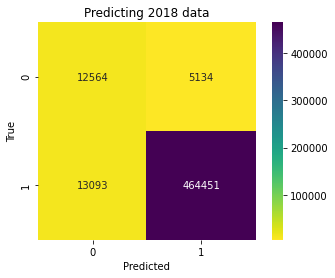

In [29]:
#predicting 2018 data
predictions = cat1.predict(pool_2018)
cm = confusion_matrix(test_target, predictions)
import seaborn as sns
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Predicting 2018 data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

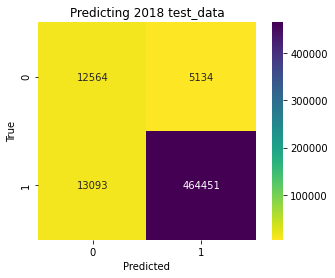

In [45]:
#predicting 2018 data using just test_data dataframe
predictions = cat1.predict(test_data)
cm = confusion_matrix(test_target, predictions)
import seaborn as sns
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Predicting 2018 test_data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [32]:
#computing ROC-AUC score for Catboost on 2018 data 

roc_auc_score(test_target, predictions)

0.841246677752457

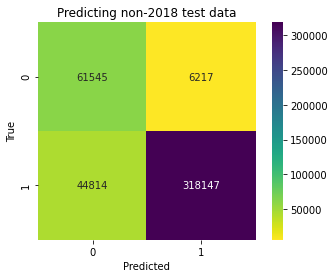

In [34]:
#predicting <2018 test data that model hasn't seen yet
predictions2 = cat1.predict(pool_test)
cm1 = confusion_matrix(y_test, predictions2)
import seaborn as sns
ax = sns.heatmap(cm1, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Predicting non-2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [32]:
#accuracy, precision and recall scores of CatBoost predictions on the 2018 data

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
ac1 = accuracy_score(test_target, predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr1 = precision_score(test_target, predictions)
re1 = recall_score(test_target, predictions)
print('Accuracy Score of %{:.4f}'.format(ac1))
print('Precision Score of %{:.4f}'.format(pr1))
print('Recall Score of %{:.4f}'.format(re1))

Accuracy Score of %0.9632
Precision Score of %0.9891
Recall Score of %0.9726


In [33]:
#accuracy, precision and recall scores of CatBoost predictions on the non-2018 data

ac2 = accuracy_score(y_test, predictions2)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr2 = precision_score(y_test, predictions2)
re2 = recall_score(y_test, predictions2)
print('Accuracy Score of %{:.4f}'.format(ac2))
print('Precision Score of %{:.4f}'.format(pr2))
print('Recall Score of %{:.4f}'.format(re2))

Accuracy Score of %0.8815
Precision Score of %0.9808
Recall Score of %0.8765


In [35]:
#roc_auc_score of Catboost on the non-2018 data 
roc_auc_score(y_test, predictions2)

0.8923923011327715

In [132]:
#looking at feature importances of CatBoostClassifier model

cat_coefficients = pd.DataFrame(cat1.feature_importances_.reshape(-1))
column_names = pd.DataFrame(x_train_lg.columns.values)
cat_feat_imp = pd.concat([cat_coefficients, column_names], axis = 1)
cat_feat_imp.columns = ['Importance','Feature_Name']
print_full(cat_feat_imp.sort_values(by='Importance', ascending = False))

     Importance                         Feature_Name
19    50.143324                          open_il_12m
72     4.969540                         sub_grade_B4
5      4.706199                           annual_inc
0      3.623940                            loan_amnt
7      2.664881                          delinq_2yrs
2      2.251541                             int_rate
1      2.012857                                 term
13     1.833262                 last_fico_range_high
3      1.802457                          installment
17     1.751052                          open_acc_6m
11     1.563262                            revol_bal
73     1.513077                         sub_grade_B5
58     1.158987                     percent_bc_gt_75
21     1.137145                   mths_since_rcnt_il
64     1.115095           earliest_credit_line_years
57     1.014519                       pct_tl_nvr_dlq
45     0.937616                       num_actv_bc_tl
41     0.795690                             mo

In [170]:
#taking the top CatBoostClassifier open_il_12m and annual_inc features and retraining another model 
#to then 3D visualize probability estimation 

#creating data with just our two features 
train_data_2feat = train_data.loc[:,['open_il_12m','annual_inc']]

#creating new train, val and test sets 
x_train_2feat, x_test_2feat, y_train_2feat, y_test_2feat = train_test_split(train_data_2feat, train_target, stratify = train_target, 
                                                    random_state = 0)
x_train_2feat, x_val_2feat, y_train_2feat, y_val_2feat = train_test_split(x_train_2feat, y_train_2feat, stratify = y_train_2feat, 
                                                    random_state = 0)
num1 = y_train.value_counts()
pool_train_2feat = Pool(x_train_2feat, y_train_2feat)
pool_test_2feat = Pool(x_test_2feat, y_test_2feat)
pool_val_2feat = Pool(x_val_2feat, y_val_2feat)

cat2feat = CatBoostClassifier(learning_rate = 0.05,
                          iterations = 1000,
                          early_stopping_rounds=100,
                          class_weights = [1, num[0]/num[1]])

cat2feat.fit(pool_train_2feat, eval_set=pool_val_2feat, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6923579	test: 0.6923388	best: 0.6923388 (0)	total: 635ms	remaining: 10m 34s
1:	learn: 0.6916065	test: 0.6915668	best: 0.6915668 (1)	total: 950ms	remaining: 7m 54s
2:	learn: 0.6909559	test: 0.6909007	best: 0.6909007 (2)	total: 1.65s	remaining: 9m 9s
3:	learn: 0.6903559	test: 0.6902859	best: 0.6902859 (3)	total: 1.97s	remaining: 8m 11s
4:	learn: 0.6897938	test: 0.6897084	best: 0.6897084 (4)	total: 2.73s	remaining: 9m 2s
5:	learn: 0.6893002	test: 0.6892038	best: 0.6892038 (5)	total: 3.2s	remaining: 8m 50s
6:	learn: 0.6888500	test: 0.6887431	best: 0.6887431 (6)	total: 3.69s	remaining: 8m 42s
7:	learn: 0.6884298	test: 0.6883125	best: 0.6883125 (7)	total: 4.1s	remaining: 8m 28s
8:	learn: 0.6880599	test: 0.6879299	best: 0.6879299 (8)	total: 4.41s	remaining: 8m 5s
9:	learn: 0.6877317	test: 0.6875932	best: 0.6875932 (9)	total: 4.61s	remaining: 7m 36s
10:	learn: 0.6874048	test: 0.6872565	best: 0.6872565 (10)	total: 4.95s	remaining: 7m 24s
11:	learn: 0.6871278	test: 0.6869677	best: 0.

93:	learn: 0.6840510	test: 0.6837029	best: 0.6837029 (93)	total: 27.5s	remaining: 4m 24s
94:	learn: 0.6840491	test: 0.6837027	best: 0.6837027 (94)	total: 27.6s	remaining: 4m 23s
95:	learn: 0.6840477	test: 0.6837012	best: 0.6837012 (95)	total: 27.9s	remaining: 4m 22s
96:	learn: 0.6840459	test: 0.6837002	best: 0.6837002 (96)	total: 28.1s	remaining: 4m 21s
97:	learn: 0.6840444	test: 0.6836986	best: 0.6836986 (97)	total: 28.4s	remaining: 4m 21s
98:	learn: 0.6840426	test: 0.6836980	best: 0.6836980 (98)	total: 28.7s	remaining: 4m 21s
99:	learn: 0.6840417	test: 0.6836973	best: 0.6836973 (99)	total: 28.9s	remaining: 4m 19s
100:	learn: 0.6840404	test: 0.6836971	best: 0.6836971 (100)	total: 29.1s	remaining: 4m 19s
101:	learn: 0.6840374	test: 0.6836953	best: 0.6836953 (101)	total: 29.4s	remaining: 4m 18s
102:	learn: 0.6840353	test: 0.6836947	best: 0.6836947 (102)	total: 29.7s	remaining: 4m 18s
103:	learn: 0.6840340	test: 0.6836935	best: 0.6836935 (103)	total: 29.9s	remaining: 4m 17s
104:	learn: 0

184:	learn: 0.6839411	test: 0.6836714	best: 0.6836661 (179)	total: 50.5s	remaining: 3m 42s
185:	learn: 0.6839405	test: 0.6836717	best: 0.6836661 (179)	total: 50.8s	remaining: 3m 42s
186:	learn: 0.6839395	test: 0.6836714	best: 0.6836661 (179)	total: 51s	remaining: 3m 41s
187:	learn: 0.6839394	test: 0.6836708	best: 0.6836661 (179)	total: 51.2s	remaining: 3m 41s
188:	learn: 0.6839386	test: 0.6836708	best: 0.6836661 (179)	total: 51.4s	remaining: 3m 40s
189:	learn: 0.6839379	test: 0.6836705	best: 0.6836661 (179)	total: 51.7s	remaining: 3m 40s
190:	learn: 0.6839372	test: 0.6836707	best: 0.6836661 (179)	total: 52s	remaining: 3m 40s
191:	learn: 0.6839362	test: 0.6836699	best: 0.6836661 (179)	total: 52.2s	remaining: 3m 39s
192:	learn: 0.6839353	test: 0.6836686	best: 0.6836661 (179)	total: 52.4s	remaining: 3m 39s
193:	learn: 0.6839342	test: 0.6836678	best: 0.6836661 (179)	total: 52.7s	remaining: 3m 38s
194:	learn: 0.6839333	test: 0.6836671	best: 0.6836661 (179)	total: 53.4s	remaining: 3m 40s
195

275:	learn: 0.6838620	test: 0.6836571	best: 0.6836569 (273)	total: 1m 14s	remaining: 3m 15s
276:	learn: 0.6838609	test: 0.6836578	best: 0.6836569 (273)	total: 1m 14s	remaining: 3m 15s
277:	learn: 0.6838595	test: 0.6836574	best: 0.6836569 (273)	total: 1m 15s	remaining: 3m 15s
278:	learn: 0.6838580	test: 0.6836572	best: 0.6836569 (273)	total: 1m 15s	remaining: 3m 14s
279:	learn: 0.6838576	test: 0.6836574	best: 0.6836569 (273)	total: 1m 15s	remaining: 3m 14s
280:	learn: 0.6838566	test: 0.6836571	best: 0.6836569 (273)	total: 1m 15s	remaining: 3m 13s
281:	learn: 0.6838553	test: 0.6836563	best: 0.6836563 (281)	total: 1m 16s	remaining: 3m 13s
282:	learn: 0.6838539	test: 0.6836563	best: 0.6836563 (281)	total: 1m 16s	remaining: 3m 13s
283:	learn: 0.6838529	test: 0.6836580	best: 0.6836563 (281)	total: 1m 16s	remaining: 3m 12s
284:	learn: 0.6838514	test: 0.6836568	best: 0.6836563 (281)	total: 1m 16s	remaining: 3m 12s
285:	learn: 0.6838497	test: 0.6836569	best: 0.6836563 (281)	total: 1m 16s	remain

365:	learn: 0.6837487	test: 0.6836538	best: 0.6836504 (341)	total: 1m 37s	remaining: 2m 48s
366:	learn: 0.6837468	test: 0.6836524	best: 0.6836504 (341)	total: 1m 37s	remaining: 2m 48s
367:	learn: 0.6837458	test: 0.6836520	best: 0.6836504 (341)	total: 1m 37s	remaining: 2m 48s
368:	learn: 0.6837442	test: 0.6836522	best: 0.6836504 (341)	total: 1m 38s	remaining: 2m 47s
369:	learn: 0.6837427	test: 0.6836540	best: 0.6836504 (341)	total: 1m 38s	remaining: 2m 47s
370:	learn: 0.6837415	test: 0.6836542	best: 0.6836504 (341)	total: 1m 38s	remaining: 2m 47s
371:	learn: 0.6837407	test: 0.6836548	best: 0.6836504 (341)	total: 1m 38s	remaining: 2m 47s
372:	learn: 0.6837389	test: 0.6836542	best: 0.6836504 (341)	total: 1m 39s	remaining: 2m 46s
373:	learn: 0.6837377	test: 0.6836536	best: 0.6836504 (341)	total: 1m 39s	remaining: 2m 46s
374:	learn: 0.6837356	test: 0.6836524	best: 0.6836504 (341)	total: 1m 39s	remaining: 2m 46s
375:	learn: 0.6837348	test: 0.6836524	best: 0.6836504 (341)	total: 1m 39s	remain

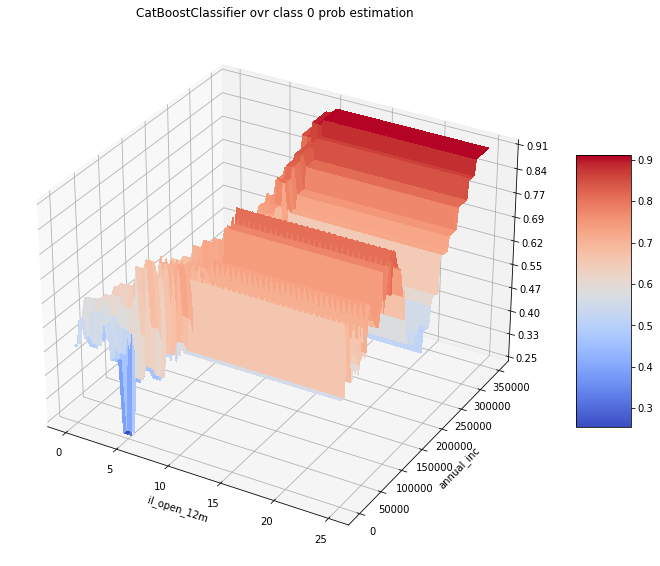

In [160]:
#creating 3D graphic view of open_il_12m vs annual_inc variables

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,25,100)
B = np.linspace(0,350000,100)
A, B = np.meshgrid(A, B)

C = cat1.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,0].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'CatBoostClassifier ovr class 0 prob estimation')
plt.xlabel('il_open_12m')
plt.ylabel('annual_inc')
plt.show()

In [162]:
#predictions using 2-feat Catboost Classifier model 
cat_2feat_predictions = cat2feat.predict(x_test_2feat)

ac_2feat = accuracy_score(y_test_2feat, cat_2feat_predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr_2feat = precision_score(y_test_2feat, cat_2feat_predictions)
re_2feat = recall_score(y_test_2feat, cat_2feat_predictions)
print('2-feat Catboost Classifier model Accuracy Score of %{:.4f}'.format(ac_2feat))
print('2-feat Catboost Classifier model Precision Score of %{:.4f}'.format(pr_2feat))
print('2-feat Catboost Classifier model Recall Score of %{:.4f}'.format(re_2feat))

2-feat Catboost Classifier model Accuracy Score of %0.5397
2-feat Catboost Classifier model Precision Score of %0.8715
2-feat Catboost Classifier model Recall Score of %0.5323


In [23]:
#Merging our data to do logistic regression
re_merged = pd.concat([train_data, test_data], axis = 0)
re_merged = pd.get_dummies(re_merged, drop_first = True)
re_merged.earliest_credit_line_years = re_merged.earliest_credit_line_years.dt.days

re_merged['Year'] = pd.DatetimeIndex(re_merged['issue_d_date']).year
re_merged.drop(['earliest_cr_line_date','issue_d_date'], axis = 1, inplace = True)
#train data is all non-2018 data
traindf2 = re_merged[re_merged['Year'] != 2018]
#target data is all 2018 data 
targetdf2 = re_merged[re_merged['Year'] == 2018]
targetdf2.drop(['Year'], axis = 1, inplace = True)
traindf2.drop(['Year'], axis = 1, inplace = True)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
#traindf2 is non-2018 data, train_target is non-2018 data 

x_train_lg, x_test_lg, y_train_lg, y_test_lg = train_test_split(traindf2, train_target, random_state = 0,
                                                               test_size = 0.33)

In [127]:
#training a Logistic Regression model on the data
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

class_weight = {1:1, 0:np.round(y_train_lg.value_counts()[1]/y_train_lg.value_counts()[0],2)}

lg1 = LogisticRegression(solver = 'saga', class_weight = {1:1,0:5.36},
                        max_iter = 300, C = 1e3, n_jobs = -1)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
# cv = StratifiedKFold(n_splits = 3, random_state = 1)
# scores_lg = cross_val_score(lg1, x_train_lg, y_train_lg, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC for Logit Regression: %.3f' % np.mean(scores_lg))

In [128]:
#fitting and predicting our Logistic Regression model
lg1.fit(x_train_lg, y_train_lg)
lg1predictions = lg1.predict(x_test_lg)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [130]:
#getting Logistic Regression ROC_AUC score for the non-2018 data
roc_auc_score(y_test_lg, lg1predictions)

0.5827488773029093

In [143]:
#getting Logistic Regression ROC_AUC score for the 2018 data

lg1prediction_2018 = lg1.predict(targetdf2)
roc_auc_score(test_target, lg1prediction_2018)

0.5631836143417641

In [30]:
#pickling our lg1 model

with open('lg1.pickle','wb') as lg1_path:
    pickle.dump(lg1, lg1_path)

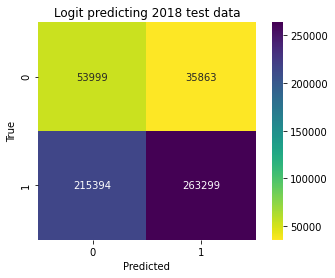

In [43]:
#visualizing the confusion matrix for Logistic Regression model
import seaborn as sns
cm2 = confusion_matrix(y_test_lg, lg1predictions)
ax = sns.heatmap(cm2, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Logit predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [62]:
#accuracy, precision and recall scores of logit predictions on the non-2018 data

ac3 = accuracy_score(y_test_lg, lg1predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr3 = precision_score(y_test_lg, lg1predictions)
re3 = recall_score(y_test_lg, lg1predictions)
print('Logit Accuracy Score of %{:.4f}'.format(ac3))
print('Logit Precision Score of %{:.4f}'.format(pr3))
print('Logit Recall Score of %{:.4f}'.format(re3))

Logit Accuracy Score of %0.5581
Logit Precision Score of %0.8801
Logit Recall Score of %0.5500


In [28]:
#computing ROC-AUC score for Logit

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_lg, lg1predictions)

0.5754776034456511

In [122]:
#viewing most important Logistic Regression features 

lg_coefficients = pd.DataFrame(lg1.coef_.reshape(-1))
column_names = pd.DataFrame(x_train_lg.columns.values)
lg_feat_imp = pd.concat([lg_coefficients, column_names], axis = 1)
lg_feat_imp.columns = ['Importance', 'Feature_Name']

In [ ]:
lg_feat_imp

In [ ]:
print_full(lg_feat_imp.sort_values(by = 'Importance'))

In [188]:
#using Recursive Feature Elimination with Logistic Regression

from sklearn.feature_selection import RFE
rfe = RFE(estimator=lg1)
rfe = rfe.fit(x_train_lg, y_train_lg)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7

In [36]:
#NAIVE BAYES

#Quadratic Discriminant Analysis (QDA)
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
QDA.fit(x_train_lg, y_train_lg)


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(store_covariance=True)

In [37]:
#fitting and predicting with our QDA model
qdapredictions = QDA.predict(x_test_lg)

In [124]:
#computing roc_auc_score of qda model 

roc_auc_score(y_test_lg, qdapredictions)

0.6159814198742477

In [144]:
#getting QDA ROC_AUC score for the 2018 data

qda_prediction_2018 = QDA.predict(targetdf2)
roc_auc_score(test_target, qda_prediction_2018)

0.6407706836078056

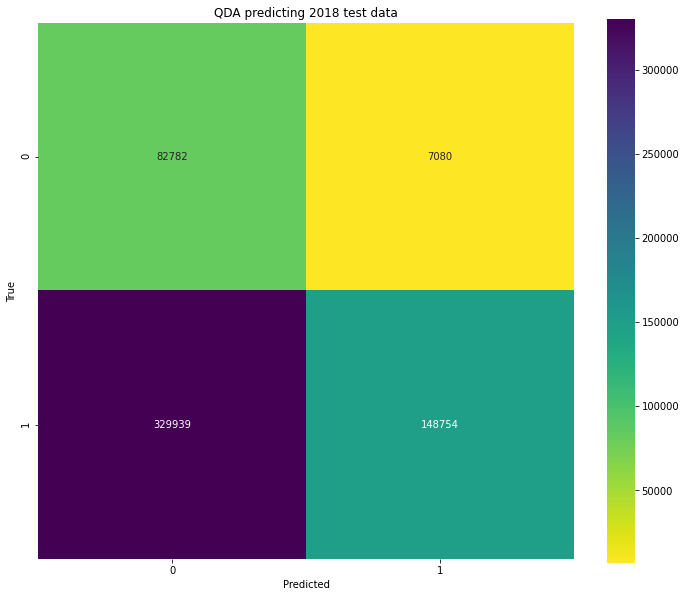

In [165]:
##visualizing the confusion matrix for QDA model
cm5 = confusion_matrix(y_test_lg, qdapredictions)
ax = sns.heatmap(cm5, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('QDA predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [166]:
#accuracy, precision and recall scores of QDA predictions on the non-2018 data

ac5 = accuracy_score(y_test_lg, qdapredictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr5 = precision_score(y_test_lg, qdapredictions)
re5 = recall_score(y_test_lg, qdapredictions)
print('QDA Accuracy Score of %{:.4f}'.format(ac5))
print('QDA Precision Score of %{:.4f}'.format(pr5))
print('QDA Recall Score of %{:.4f}'.format(re5))

Logit Accuracy Score of %0.4072
Logit Precision Score of %0.9546
Logit Recall Score of %0.3108


In [38]:
#roc_auc_score of our QDA model

roc_auc_score(y_test_lg, qdapredictions)

0.6159814198742477

In [119]:
#pickling our qda model 

with open('qda_model.pickle', 'wb') as qda_model_file:
    pickle.dump(QDA, qda_model_file)

In [167]:
x_train_lg.shape

(1154336, 172)

In [52]:
#passing subset of our x_train_lg data for demonstrative purposes 

x_train_lg1 = x_train_lg.iloc[:1000,:]
y_train_lg1 = y_train_lg[:1000]

In [56]:
#creating same-shape dataframes for test data 

x_test_lg1 = x_test_lg.iloc[:1000,:]
y_test_lg1 = y_test_lg[:1000]

In [172]:
x_train_lg1.annual_inc.dtype

dtype('float64')

In [173]:
x_train_lg1[:3]

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint,disbursement_method_DirectPay
1041258,10000.0,36,16.29,353.01,11.0,80000.0,39.11,0.0,679.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1708460,15400.0,36,14.99,533.78,6.0,35000.0,12.21,0.0,689.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2057192,32000.0,60,20.00,847.81,11.0,74500.0,16.65,0.0,699.0,2.0,...,0,0,0,0,0,0,0,1,0,0


In [175]:
str('{:,. 2f}'.format(x_train_lg1.loc[1041258, ['annual_inc']]))

TypeError: unsupported format string passed to Series.__format__

In [181]:
g = x_train_lg1.loc[104125,['annual_inc']]
g

annual_inc    80000.0
Name: 1041258, dtype: float64

In [171]:
#pickling our x_train_lg1 data

with open('x_train_lg1.pickle', 'wb') as x_train_lg1_file:
    pickle.dump(x_train_lg1, x_train_lg1_file)

In [70]:
#pickling our y_train_lg1 data

with open('y_train_lg1.pickle', 'wb') as y_train_lg1_file:
    pickle.dump(y_train_lg1, y_train_lg1_file)

In [41]:
#implementing GaussianNB algorithm for classification 
gnb = naive_bayes.GaussianNB()

gnb.fit(x_train_lg, y_train_lg)

GaussianNB()

In [147]:
#getting GaussianNB ROC_AUC score for the 2018 data

gnb_prediction_2018 = gnb.predict(targetdf2)
roc_auc_score(test_target, gnb_prediction_2018)

0.745526726703416

In [161]:
#getting GaussianNB ROC_AUC score for the non-2018 data

gnb_prediction_non2018 = gnb.predict(x_test_lg)
roc_auc_score(y_test_lg, gnb_prediction_non2018)

0.7905714601659427

In [ ]:
#predicting our non-2018 data with fitted GaussianNB model and outputting confusion matrix 

predictions_gnb = gnb.predict(x_test_lg)
cm6 = confusion_matrix(y_test_lg, predictions_gnb)

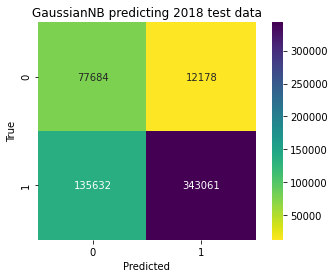

In [44]:
ax = sns.heatmap(cm6, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('GaussianNB predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [173]:
#accuracy, precision and recall scores of GNB predictions on the non-2018 data

ac6 = accuracy_score(y_test_lg, predictions_gnb)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr6 = precision_score(y_test_lg, predictions_gnb)
re6 = recall_score(y_test_lg, predictions_gnb)
print('GaussianNB Accuracy Score of %{:.4f}'.format(ac6))
print('GaussianNB Precision Score of %{:.4f}'.format(pr6))
print('GaussianNB Recall Score of %{:.4f}'.format(re6))

GaussianNB Accuracy Score of %0.7400
GaussianNB Precision Score of %0.9657
GaussianNB Recall Score of %0.7167


In [175]:
sklearn.model_selection.cross_val_score?

Object `sklearn.model_selection.cross_val_score` not found.


In [177]:
#looking at cross_val_scores for GaussianNB

scores_gnb = cross_val_score(gnb, x_train_lg, y_train_lg, scoring='roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC for GaussianNB: %.3f' % np.mean(scores_gnb))

In [149]:
#implementing MNB
mnb = naive_bayes.MultinomialNB()
mnb.fit(x_train_lg, y_train_lg)

MultinomialNB()

In [182]:
#looking at cross_val_scores for MultinomialNB
scores_mnb = cross_val_score(mnb, x_train_lg, y_train_lg, scoring='roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC for MultinomialNB: %.3f' % np.mean(scores_mnb))

Mean ROC AUC for MultinomialNB: 0.559


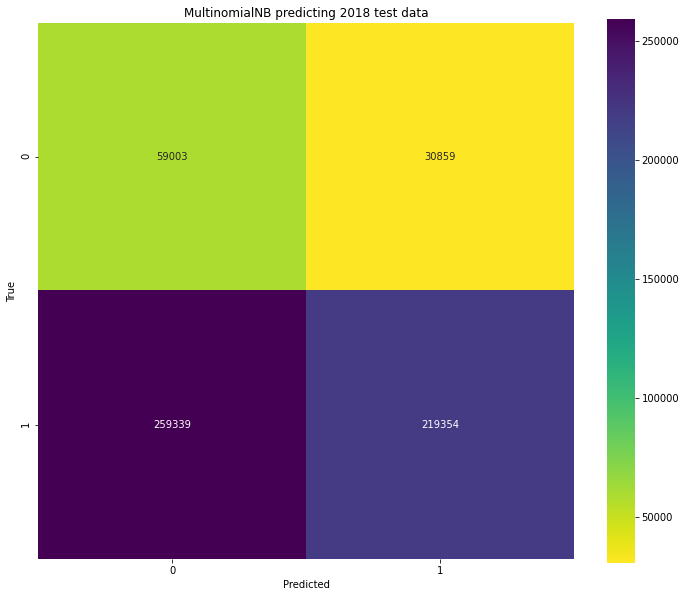

In [183]:
#predicting using MNB
predictions_mnb = mnb.predict(x_test_lg)
cm7 = confusion_matrix(y_test_lg, predictions_mnb)
ax = sns.heatmap(cm7, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('MultinomialNB predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [184]:
#looking at different scores for MultinomialNB
ac8 = accuracy_score(y_test_lg, predictions_mnb)
rs8 = recall_score(y_test_lg, predictions_mnb)
pr8 = precision_score(y_test_lg, predictions_mnb)
print('MultinomialNB Accuracy Score of %{:.4f}'.format(ac8))
print('MultinomialNB Precision Score of %{:.4f}'.format(rs8))
print('MultinomialNB Recall Score of %{:.4f}'.format(pr8))


MultinomialNB Accuracy Score of %0.4896
MultinomialNB Precision Score of %0.4582
MultinomialNB Recall Score of %0.8767


In [150]:
#getting MultinomialNB ROC_AUC score for the 2018 data

mnb_prediction_2018 = mnb.predict(targetdf2)
roc_auc_score(test_target, mnb_prediction_2018)

0.5475818937044846

In [160]:
#getting MultinomialNB ROC_AUC score for the non-2018 data

mnb_prediction_non2018 = mnb.predict(x_test_lg)
roc_auc_score(y_test_lg, mnb_prediction_non2018)

0.5574154526384514

In [132]:
#implementing Linear Discriminant Analysis (LDA)
from sklearn import discriminant_analysis
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x_train_lg, y_train_lg)

LinearDiscriminantAnalysis()

In [153]:
#getting LDA ROC_AUC score for the 2018 data

ldaprediction_2018 = lda.predict(targetdf2)
roc_auc_score(test_target, ldaprediction_2018)

0.7558750945909043

In [159]:
#getting LDA ROC_AUC score for the non-2018 data

ldaprediction_non2018 = lda.predict(x_test_lg)
roc_auc_score(y_test_lg, ldaprediction_non2018)

0.8302350480232723

In [102]:
#pickling our lda model 

with open('lda_model.pickle', 'wb') as lda_model_file:
    pickle.dump(lda, lda_model_file)

In [ ]:
#looking at cross_val_scores for Linear Discriminant Analysis
scores_lda = cross_val_score(lda, x_train_lg, y_train_lg, scoring = 'roc_auc', cv = cv, n_jobs = -1)


In [238]:
print('LinearDiscriminantAnalysis Mean Score of: %{:.3f}'.format(np.mean(scores_lda)))

LinearDiscriminantAnalysis Mean Score of: %0.943


In [277]:
lda

LinearDiscriminantAnalysis()

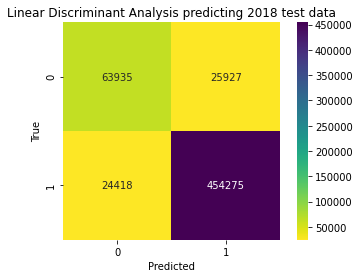

In [133]:
#predicting using LDA
predictions_lda = lda.predict(x_test_lg)
cm10 = confusion_matrix(y_test_lg, predictions_lda)
ax = sns.heatmap(cm10, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Linear Discriminant Analysis predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [134]:
roc_auc_score(predictions_lda, y_test_lg)

0.8348197403488269

In [192]:
#accuracy, precision and recall scores of GNB predictions on the non-2018 data

ac10 = accuracy_score(y_test_lg, predictions_gnb)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr10 = precision_score(y_test_lg, predictions_gnb)
re10 = recall_score(y_test_lg, predictions_gnb)
print('LinearDiscriminantAnalysis Accuracy Score of %{:.4f}'.format(ac10))
print('LinearDiscriminantAnalysis Precision Score of %{:.4f}'.format(pr10))
print('LinearDiscriminantAnalysis Recall Score of %{:.4f}'.format(re10))


LinearDiscriminantAnalysis Accuracy Score of %0.7400
LinearDiscriminantAnalysis Precision Score of %0.9657
LinearDiscriminantAnalysis Recall Score of %0.7167


In [194]:
#implementing RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 500, criterion = 'gini', class_weight = {1:1,0:5.36})
# scores_rf = cross_val_score(rf1, x_train_lg, y_train_lg, scoring='roc_auc', cv = cv, n_jobs = -1)
# print('Mean ROC AUC for Random Forests Classifier: %.3f' % np.mean(scores_rf))

In [155]:
#loading in trained RandomForests Model 
import joblib

rf2 = joblib.load('finalized_model.sav')

In [156]:
#getting ROC_AUC Score for 2018 data from our loaded Random Forests Model
rf2_prediction_2018 = rf2.predict(targetdf2)
roc_auc_score(test_target, rf2_prediction_2018)

0.6968978245598481

In [158]:
#getting ROC_AUC Score for non-2018 data from our loaded Random Forests Model
rf2_prediction_non2018 = rf2.predict(x_test_lg)
roc_auc_score(y_test_lg, rf2_prediction_non2018)

0.7689165215374484

In [ ]:
#fitting and predicting with our RandomForestClassifier model
rf1.fit(x_train_lg, y_train_lg)
rf1predictions = rf1.predict(x_test_lg)

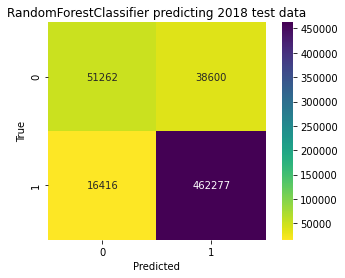

In [69]:
##visualizing the confusion matrix for RandomForestClassifier model on non-2018 data 
cm3 = confusion_matrix(y_test_lg, rf1predictions)
ax = sns.heatmap(cm3, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('RandomForestClassifier predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [71]:
#accuracy, precision and recall scores of RandomForestClassifier predictions on the non-2018 data

ac4 = accuracy_score(y_test_lg, rf1predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr4 = precision_score(y_test_lg, rf1predictions)
re4 = recall_score(y_test_lg, rf1predictions)
print('Logit Accuracy Score of %{:.4f}'.format(ac4))
print('Logit Precision Score of %{:.4f}'.format(pr4))
print('Logit Recall Score of %{:.4f}'.format(re4))

Logit Accuracy Score of %0.9032
Logit Precision Score of %0.9229
Logit Recall Score of %0.9657


In [39]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 300, max_depth = 4, validation_fraction = 0.2, n_iter_no_change = 50)
gbc.fit(x_train_lg, y_train_lg)

GradientBoostingClassifier(max_depth=4, n_estimators=300, n_iter_no_change=50,
                           validation_fraction=0.2)

In [151]:
#getting GradientBoosting ROC_AUC score for the 2018 data

gbcprediction_2018 = gbc.predict(targetdf2)
roc_auc_score(test_target, gbcprediction_2018)

0.7662183870922619

In [32]:
with open('gbc.pickle','wb') as gbc_file:
    pickle.dump(gbc, gbc_file)

In [126]:
predictions_gbc = gbc.predict(x_test_lg)
cm12 = confusion_matrix(y_test_lg, predictions_gbc)

In [ ]:
scores_gbc = cross_val_score(gbc, x_train_lg, y_train_lg, scoring='roc_auc', cv=cv, n_jobs=-1)

In [135]:
#getting single roc_auc_score, not cross-validated

roc_auc_score(y_test_lg, predictions_gbc)

0.8305568754041475

In [ ]:
#prediction
prediction

In [ ]:

roc_auc_score()

In [205]:
from sklearn.model_selection import GridSearchCV
param_grid_gbc = {'max_depth':[3,4]}
grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, scoring = 'roc_auc', cv = 3, n_jobs = -1,)

In [206]:
grid_search_gbc.fit(x_train_lg, y_train_lg)

KeyboardInterrupt: 

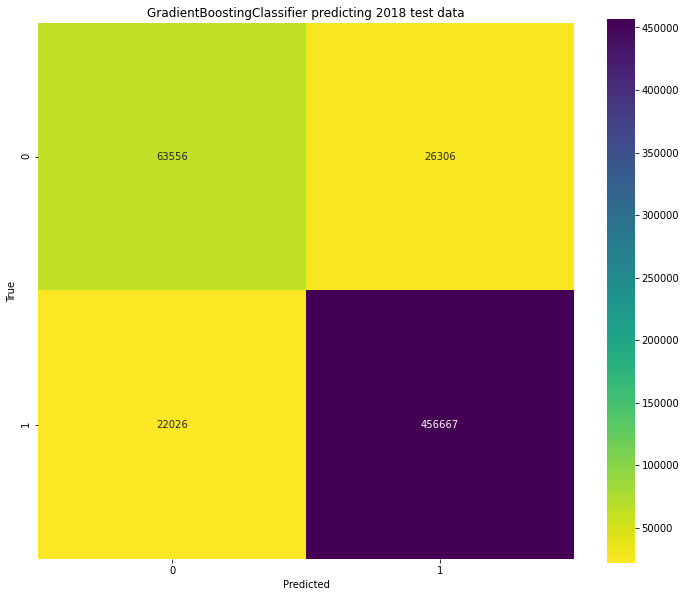

In [207]:
predictions_gbc = gbc.predict(x_test_lg)
cm11 = confusion_matrix(y_test_lg, predictions_gbc)
ax = sns.heatmap(cm11, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('GradientBoostingClassifier predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [209]:
predicted_gbc = gbc.predict_proba(x_test_lg)

In [273]:
newarr2 = np.array([1,2,3,4]).reshape(2,2)
newarr3 = np.array([5,6,7,8]).reshape(2,2)
newdf2 = pd.DataFrame(newarr2)
newdf3 = pd.DataFrame(newarr3)
concatdf = pd.concat([newdf2, newdf3], axis = 1)
concatdf.columns = ['t','t','t','t1']
concatdf

,t,t,t,t1
0,1,2,5,6
1,3,4,7,8


In [275]:
concatdf['diff'] = np.where(concatdf['t1'] != 6, 1, 0)

In [299]:
concatdf['test'] = np.where((concatdf['t1'] == 6) and (concatdf['diff'] == 1), 1, 0)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [359]:
def classification_adj(x_test_lg2, cutoff_values): #x_test_lg2 is your DataFrame with the Profit feature
    cutoff_values2 = cutoff_values[:]

    global answer
    answer = []
    
    newarr = [0] * x_test_lg2.shape[0]
    
    for cutoff in cutoff_values:
        x_test_lg2['Predicted'] = np.where(x_test_lg2['Bad_Loan'] > cutoff, 0, 1)

        x_test_lg2['cf_diff'] = np.where((x_test_lg2['Predicted'] == 0) & (x_test_lg2['True'] == 1), 
                                        x_test_lg2['False_Negative_Cost'], 
                                        np.where((x_test_lg2['Predicted'] == 1) & (x_test_lg2['True'] == 0),
                                        -1 * x_test_lg2['loan_amnt'], 0))
        
        tuple1 = tuple([cutoff, np.sum(x_test_lg2['cf_diff'])])
        answer.append(tuple1)
        
    return answer

classification_adj(x_test_lg2, list(np.linspace(0,1,100)))

[(0.0, -8386755721.214024),
 (0.010101010101010102, -3944105239.330072),
 (0.020202020202020204, -2461586168.2519436),
 (0.030303030303030304, -1905120537.5607815),
 (0.04040404040404041, -1608204574.518407),
 (0.05050505050505051, -1415714280.672393),
 (0.06060606060606061, -1277426006.2990572),
 (0.07070707070707072, -1173076757.4049282),
 (0.08080808080808081, -1084336881.0868495),
 (0.09090909090909091, -1012024752.1389229),
 (0.10101010101010102, -952801925.9215193),
 (0.11111111111111112, -899844872.8317631),
 (0.12121212121212122, -855886020.7769237),
 (0.13131313131313133, -816634688.6405116),
 (0.14141414141414144, -784176416.9476225),
 (0.15151515151515152, -753528268.0721098),
 (0.16161616161616163, -727036221.6693339),
 (0.17171717171717174, -702033097.0012451),
 (0.18181818181818182, -681073004.289234),
 (0.19191919191919193, -661418550.1283445),
 (0.20202020202020204, -644593845.2174515),
 (0.21212121212121213, -627659321.5278203),
 (0.22222222222222224, -613210375.420005

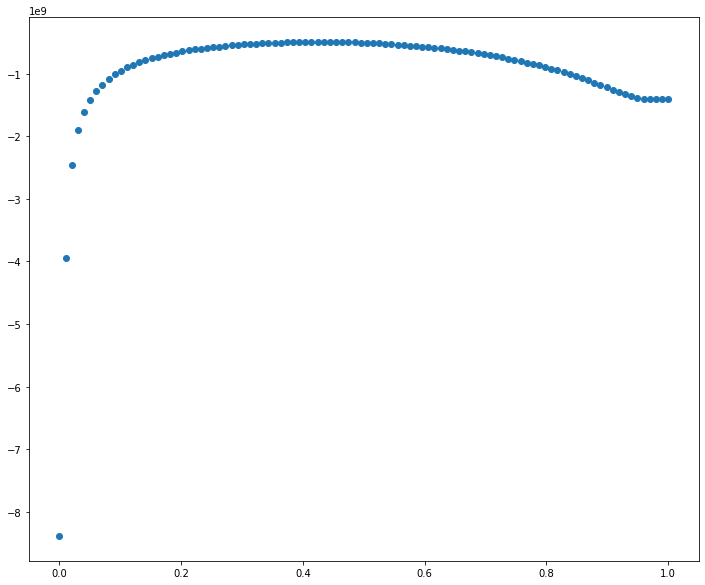

In [367]:
import matplotlib.pyplot as plt
plt.scatter(list(zip(*answer))[0],list(zip(*answer))[1])

In [25]:
#concatenating our predict_prob_cat  array to our test_data dataframe to avoid concatenation duplication later on

test_data2 = test_data.reset_index()
predict_prob_cat = pd.DataFrame(cat1.predict_proba(test_data), columns = ['Bad_Loan','Good_Loan'])
test_data2 = pd.concat([test_data2, predict_prob_cat], axis = 1)
test_data2.drop(['index'], axis = 1, inplace = True)

#making our y_test_lg Series into a DataFrame and concatenating this to our x_test_lg2
new_test_target = pd.DataFrame(test_target).reset_index()
new_test_target.drop(['index'], axis = 1, inplace = True)
new_test_target.columns = ['True']
test_data2 = pd.concat([test_data2, new_test_target], axis = 1)

#creating a new Profit feature based on loan amount, term, installment, and predicted default probability
#this will be the global metric used when optimizing for cutoff value 
test_data2['False_Negative_Cost'] = (test_data2['Good_Loan'] * test_data2['installment'] * test_data2['term'] * -1)

In [215]:
classification_adj(test_data2, list(np.linspace(0,1,100)))

[(0.0, -8841294364.423834),
 (0.010101010101010102, -8394558003.716007),
 (0.020202020202020204, -6785145247.221917),
 (0.030303030303030304, -5457920311.118082),
 (0.04040404040404041, -4481414206.108896),
 (0.05050505050505051, -3743419422.8265963),
 (0.06060606060606061, -3171972660.494451),
 (0.07070707070707072, -2728677389.9440365),
 (0.08080808080808081, -2371620927.765899),
 (0.09090909090909091, -2076428568.1939776),
 (0.10101010101010102, -1834162177.5112808),
 (0.11111111111111112, -1630608330.37746),
 (0.12121212121212122, -1460755882.133975),
 (0.13131313131313133, -1315488091.1240835),
 (0.14141414141414144, -1191256223.857706),
 (0.15151515151515152, -1083609724.2779427),
 (0.16161616161616163, -990222708.2359495),
 (0.17171717171717174, -904892377.8556539),
 (0.18181818181818182, -833946881.6778455),
 (0.19191919191919193, -768523171.1281987),
 (0.20202020202020204, -711439539.7581367),
 (0.21212121212121213, -659545161.3637681),
 (0.22222222222222224, -614631176.969803

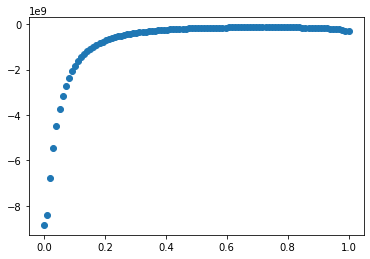

In [216]:
#visualizing cutoff threshold scatter plot for our cat boost model 
import matplotlib.pyplot as plt
plt.scatter(list(zip(*answer))[0],list(zip(*answer))[1])

In [ ]:
#accuracy, precision and recall scores of GradientBoostingClassifier predictions on non-2018 data

ac11 = accuracy_score(y_test_lg, predictions_gbc)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr11 = precision_score(y_test_lg, predictions_gbc)
re11 = recall_score(y_test_lg, predictions_gbc)
print('GradientBoostingClassifier Accuracy Score of %{:.4f}'.format(ac11))
print('GradientBoostingClassifier Precision Score of %{:.4f}'.format(pr11))
print('GradientBoostingClassifier Recall Score of %{:.4f}'.format(re11))

In [27]:
def cashflowseries(installment, loan_amnt, term, default_rate):
    
    dates36 = ['10/1/2020','11/1/2020','12/1/2020',
         '1/1/2021','2/1/2021','3/1/2021','4/1/2021','5/1/2021','6/1/2021',
         '7/1/2021','8/1/2021','9/1/2021','10/1/2021','11/1/2021','12/1/2021',
         '1/1/2022','2/1/2022','3/1/2022','4/1/2022','5/1/2022','6/1/2022',
         '7/1/2022','8/1/2022','9/1/2022','10/1/2022','11/1/2022','12/1/2022',
         '1/1/2023','2/1/2023','3/1/2023','4/1/2023','5/1/2023','6/1/2023',
         '7/1/2023','8/1/2023','9/1/2023','10/1/2023']
    dates60 = ['10/1/2020','11/1/2020','12/1/2020',
         '1/1/2021','2/1/2021','3/1/2021','4/1/2021','5/1/2021','6/1/2021',
         '7/1/2021','8/1/2021','9/1/2021','10/1/2021','11/1/2021','12/1/2021',
         '1/1/2022','2/1/2022','3/1/2022','4/1/2022','5/1/2022','6/1/2022',
         '7/1/2022','8/1/2022','9/1/2022','10/1/2022','11/1/2022','12/1/2022',
         '1/1/2023','2/1/2023','3/1/2023','4/1/2023','5/1/2023','6/1/2023',
         '7/1/2023','8/1/2023','9/1/2023','10/1/2023','11/1/2023','12/1/2023',
          '1/1/2024','2/1/2024','3/1/2024','4/1/2024','5/1/2024','6/1/2024',
         '7/1/2024','8/1/2024','9/1/2024','10/1/2024','11/1/2024','12/1/2024',
         '1/1/2025','2/1/2025','3/1/2025','4/1/2025','5/1/2025','6/1/2025',
         '7/1/2025','8/1/2025','9/1/2025','10/1/2025']
    
    datelist = []
    
    if term == 36:
        dates = dates36
        for idx, x in enumerate(dates):
            if idx == 0:
                datelist.append(tuple([pd.to_datetime(dates[idx]), loan_amnt * -1]))
            else:
                datelist.append(tuple([pd.to_datetime(dates[idx]), installment * default_rate]))
                
    elif term == 60:
        dates = dates60
        for idx, x in enumerate(dates):
            if idx == 0:
                datelist.append(tuple([pd.to_datetime(dates[idx]), loan_amnt * -1]))
            else:
                datelist.append(tuple([pd.to_datetime(dates[idx]), installment * default_rate]))    
    return datelist
    

In [222]:
test_data2['ave_default'] = (1 - test_data2['Bad_Loan'])

In [ ]:
test_data2['ave_non_default'] = (1 - test_data2['Bad_Loan'])

In [28]:
test_data2['cashflows'] = test_data2.apply(lambda x: cashflowseries(x.installment, x.loan_amnt, x.term, x.ave_non_default), axis = 1)

In [30]:
from scipy import optimize
def xnpv(rate,cashflows):
    """
    Calculate the net present value of a series of cashflows at irregular intervals.
    Arguments
    ---------
    * rate: the discount rate to be applied to the cash flows
    * cashflows: a list object in which each element is a tuple of the form (date, amount), where date is a python datetime.date object and amount is an integer or floating point number. Cash outflows (investments) are represented with negative amounts, and cash inflows (returns) are positive amounts.
    
    Returns
    -------
    * returns a single value which is the NPV of the given cash flows.
    Notes
    ---------------
    * The Net Present Value is the sum of each of cash flows discounted back to the date of the first cash flow. 
    The discounted value of a given cash flow is A/(1+r)**(t-t0), where A is the amount, r is the discout rate, 
    and (t-t0) is the time in years from the date of the first cash flow in the series (t0) to the date of the cash flow 
    being added to the sum (t).  
    * This function is equivalent to the Microsoft Excel function of the same name. 
    """
    chron_order = sorted(cashflows, key = lambda x: x[0])
    t0 = chron_order[0][0] #t0 is the date of the first cash flow

    try:
        return sum([cf/(1+rate)**((t-t0).days/365.0) for (t,cf) in chron_order])
    except:
        print('Error')
    return 0
    

def xirr(cashflows,guess=0):
    """
    Calculate the Internal Rate of Return of a series of cashflows at irregular intervals.
    Arguments
    ---------
    * cashflows: a list object in which each element is a tuple of the form (date, amount), 
    where date is a python datetime.date object and amount is an integer or floating point number. 
    Cash outflows (investments) are represented with negative amounts, and cash inflows (returns) are positive amounts.
    * guess (optional, default = 0.1): a guess at the solution to be used as a starting point for the numerical solution. 
    Returns
    --------
    * Returns the IRR as a single value
    
    Notes
    ----------------
    * The Internal Rate of Return (IRR) is the discount rate at which the Net Present Value (NPV) of a series of cash flows is equal to zero. The NPV of the series of cash flows is determined using the xnpv function in this module. The discount rate at which NPV equals zero is found using the secant method of numerical solution. 
    * This function is equivalent to the Microsoft Excel function of the same name.
    * For users that do not have the scipy module installed, there is an alternate version (commented out) that uses the secant_method function defined in the module rather than the scipy.optimize module's numerical solver. Both use the same method of calculation so there should be no difference in performance, but the secant_method function does not fail gracefully in cases where there is no solution, so the scipy.optimize.newton version is preferred.
    """

    return optimize.brentq(lambda r: xnpv(r,cashflows),-0.99999, 100)


In [31]:
test_data2['xirr'] = test_data2['cashflows'].apply(lambda x: xirr(x))

In [32]:
test_data2['xirr']

0        -0.156431
1         0.077106
2         0.058112
3         0.087056
4         0.064503
            ...   
495237    0.092813
495238   -0.727031
495239    0.117579
495240    0.086333
495241    0.050577
Name: xirr, Length: 495242, dtype: float64

In [34]:
cashflows1 = test_data2['cashflows'][:]

In [36]:
test_data2.drop(['cashflows'], axis = 1, inplace = True)

In [438]:
#Looking at feature importances of catboost classifieralgorithm 
importances = cat1.feature_importances_
feat_imp_df = pd.DataFrame([x_train.columns.values, importances]).T   
feat_imp_df.columns = ['Feature','Imp']
print_full(feat_imp_df.sort_values(by = 'Imp', ascending = False))

                       Feature         Imp
18        last_fico_range_high     51.8902
2                  installment     4.88592
71                issue_d_date     4.79769
4                   emp_length     4.07705
0                         term     2.79069
1                     int_rate     1.98569
12             fico_range_high     1.90045
6                   annual_inc     1.87182
16                   total_acc     1.64672
10                         dti     1.37166
57         num_rev_tl_bal_gt_0     1.16789
72       earliest_cr_line_date     1.01975
63              pct_tl_nvr_dlq     1.00938
56               num_rev_accts    0.989224
20            application_type    0.971082
44        mo_sin_old_rev_tl_op    0.901069
9                   addr_state    0.859795
33            total_rev_hi_lim    0.852816
40                     bc_util    0.714782
73  earliest_credit_line_years    0.684156
39              bc_open_to_buy     0.66317
69  total_il_high_credit_limit    0.610489
28         

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 1)
test1 = imputer.fit_transform(accepted_df[['num_rev_accts','total_acc']])
test1

In [ ]:
#come back to this later --last_credit_pull_d
#missing value should be filled with mode of observations with same issue_d --use groupby
accepted_df2 = accepted_df['last_credit_pull_d'].fillna(accepted_df.groupby(['issue_d']).transform(lambda x: x.mode().iloc[0]))
print_full(pd.DataFrame(accepted_df2))

accepted_df['last_credit_pull_d'] = accepted_df.groupby(['issue_d'])['last_credit_pull_d'].agg(pd.Series.mode)

In [230]:
accepted_df_na2 = (accepted_df.isna().sum()).reset_index()
accepted_df_na2.columns = ['Feature','NAs']
print_full(accepted_df_na2[accepted_df_na2['NAs'] > 0 ].sort_values(by = ['NAs']))

Empty DataFrame
Columns: [Feature, NAs]
Index: []


In [ ]:
#imputing missing values in certain columns with simple linear regression
from sklearn.linear_model import LinearRegression
regress_features = ['dti']
lnreg = LinearRegression()
for x in regress_features:
    missing_index = accepted_df[x].isna().index
    accepted_df[x] = 

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=1, random_state=0)
imp.fit(accepted_df[num_feat])
imp.transform(accepted_df['dti'])

In [17]:
from sklearn.impute import SimpleImputer
df1 = pd.DataFrame([[1,np.nan,3],[4,5,np.nan]], columns = ['a','b','c'])
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean.fit(df1)
X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
imp_mean.transform(X)

array([[ 2.5,  2. ,  3. ],
       [ 4. ,  5. ,  6. ],
       [10. ,  5. ,  9. ]])

(0.0, 300000.0)

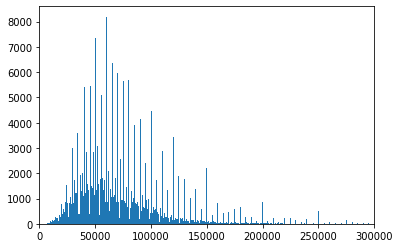

In [141]:
#EDA on annual_inc
import matplotlib.pyplot as plt
plt.hist(accepted_df['annual_inc'][:200000],10000)
plt.xlim(0,300000)

In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [50]:
model.fit(X, y, epochs=150, batch_size=10)

Epoch 1/150
77/77 [==============================] - 0s 2ms/step - loss: 5.6935 - accuracy: 0.5306
Epoch 2/150
77/77 [==============================] - 0s 3ms/step - loss: 1.6330 - accuracy: 0.4628
Epoch 3/150
77/77 [==============================] - 0s 2ms/step - loss: 0.8970 - accuracy: 0.5502
Epoch 4/150
77/77 [==============================] - 0s 2ms/step - loss: 0.7417 - accuracy: 0.6010
Epoch 5/150
77/77 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.6323
Epoch 6/150
77/77 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.6506
Epoch 7/150
77/77 [==============================] - 0s 2ms/step - loss: 0.6355 - accuracy: 0.6649
Epoch 8/150
77/77 [==============================] - 0s 2ms/step - loss: 0.6326 - accuracy: 0.6662
Epoch 9/150
77/77 [==============================] - 0s 2ms/step - loss: 0.6165 - accuracy: 0.6675
Epoch 10/150
77/77 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.6819
Epoch 11/

77/77 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.7314
Epoch 83/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5204 - accuracy: 0.7432
Epoch 84/150
77/77 [==============================] - 0s 3ms/step - loss: 0.5212 - accuracy: 0.7510
Epoch 85/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5373 - accuracy: 0.7275
Epoch 86/150
77/77 [==============================] - 0s 1ms/step - loss: 0.5196 - accuracy: 0.7432
Epoch 87/150
77/77 [==============================] - 0s 4ms/step - loss: 0.5293 - accuracy: 0.7536
Epoch 88/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5281 - accuracy: 0.7432
Epoch 89/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.7314
Epoch 90/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.7484
Epoch 91/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.7353
Epoch 92/150


In [51]:
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

24/24 [==============================] - 0s 2ms/step - loss: 0.4751 - accuracy: 0.7731
Accuracy: 77.31


In [53]:
x_train_lg1

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint,disbursement_method_DirectPay
1041258,10000.0,36,16.29,353.01,11.00000,80000.0,39.11,0.0,679.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1708460,15400.0,36,14.99,533.78,6.00000,35000.0,12.21,0.0,689.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2057192,32000.0,60,20.00,847.81,11.00000,74500.0,16.65,0.0,699.0,2.0,...,0,0,0,0,0,0,0,1,0,0
271881,15000.0,36,17.86,541.24,4.00000,40000.0,10.71,0.0,674.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1000197,9000.0,36,11.99,298.89,6.30794,64000.0,14.06,0.0,679.0,1.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936104,15000.0,36,13.59,509.69,6.00000,50000.0,21.70,0.0,679.0,2.0,...,0,0,0,0,0,0,0,0,0,0
890163,10000.0,36,12.62,335.12,5.00000,72000.0,8.22,0.0,709.0,1.0,...,0,0,0,0,0,0,0,1,0,0
87123,15000.0,60,9.17,312.62,6.30794,100000.0,14.32,0.0,734.0,2.0,...,0,0,0,0,0,0,0,1,0,0
107411,24000.0,36,10.99,785.62,1.00000,145000.0,26.26,0.0,719.0,2.0,...,0,0,0,0,0,0,0,1,0,0


In [86]:
x_train_lg2 = x_train_lg #[:50000]
x_test_lg2 = x_test_lg #[:50000]
y_train_lg2 = y_train_lg #[:50000]
y_test_lg2 = y_test_lg #[:50000]

In [87]:
#implementing a neural network on our Lending Club dataset 
#scaling non-2018 data 

cols = x_train_lg1.columns
cols = list(cols)

x = x_train_lg2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train = pd.DataFrame(x_scaled)
X_train.columns = cols

x = x_test_lg2.values #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)
X_test = pd.DataFrame(x_scaled)
X_test.columns = cols

In [169]:
#scaling 2018 data to make predictions using neural net trained on non-2018 data 

cols2 = targetdf2.columns
cols2 = list(cols)

x2 = targetdf2.values #returns a numpy array
x2_scaled = min_max_scaler.fit_transform(x2)
X_train_2018 = pd.DataFrame(x2_scaled)
X_train_2018.columns = cols2

In [88]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test_lg2, test_size = 0.50, random_state = 777)

In [89]:
#train neural network and use F1 as evaluation metric

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [90]:
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from matplotlib import pyplot 

model = Sequential()
model.add(Dense(4096, input_shape = (len(X_train.columns),), activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='linear'))
model.add(Dense(1, activation = 'sigmoid'))

opt = optimizers.RMSprop(lr=0.00001) # default is 0.001
model.compile(optimizer = opt,
             loss = 'binary_crossentropy',
             metrics = ['accuracy', f1])

# Adjust the weights of the classes since your dataset is HIGHLY IMBALANCED!
class_weight = {0: 4.25,
                1: 1.}

model.fit(X_train,
         y_train_lg2,
         epochs = 4,
         batch_size = 512,
         validation_data = (X_val, y_val), class_weight=class_weight,
         callbacks=[EarlyStopping(monitor='val_f1', mode='max', patience=30, restore_best_weights=True)])

#let's get the training and validation accuracies for plotting
val_acc = model.history.history['val_acc']
acc = model.history.history['acc']


Epoch 1/4
2255/2255 [==============================] - 1722s 764ms/step - loss: 0.6625 - accuracy: 0.8400 - f1: 0.9006 - val_loss: 0.3452 - val_accuracy: 0.8563 - val_f1: 0.9082
Epoch 2/4
2255/2255 [==============================] - 2142s 950ms/step - loss: 0.4835 - accuracy: 0.8803 - f1: 0.9253 - val_loss: 0.2818 - val_accuracy: 0.8842 - val_f1: 0.9278
Epoch 3/4
2255/2255 [==============================] - 2545s 1s/step - loss: 0.4728 - accuracy: 0.8817 - f1: 0.9262 - val_loss: 0.3379 - val_accuracy: 0.8566 - val_f1: 0.9084
Epoch 4/4
2255/2255 [==============================] - 1664s 738ms/step - loss: 0.4687 - accuracy: 0.8821 - f1: 0.9265 - val_loss: 0.2787 - val_accuracy: 0.8837 - val_f1: 0.9275


KeyError: 'val_acc'

In [91]:
val_acc = model.history.history['val_accuracy']
acc = model.history.history['accuracy']

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 4096)              708608    
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)              

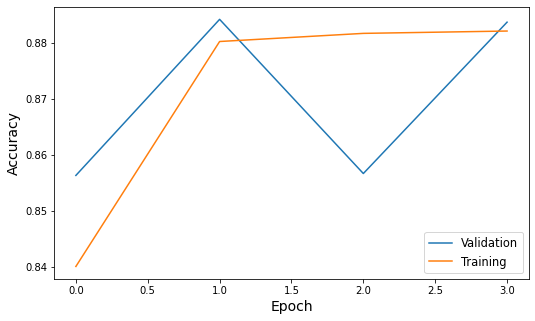

In [92]:
print(model.summary())
# let's plot the performance curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_acc, label='Validation')
plt.plot(acc, label = 'Training')
plt.gcf().set_size_inches(8.5, 5)
plt.xlabel('Epoch',size=14)
plt.ylabel('Accuracy',size=14)
plt.legend(loc="lower right", prop={'size':11.5})
plt.show()

In [93]:
from sklearn.metrics import accuracy_score
y_prediction = model.predict_classes(X_test)
print("The Test Accuracy of the model is: {} %".format(accuracy_score(y_test, y_prediction) * 100.)) 
print()

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_prediction))
print()

from sklearn.metrics import classification_report
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_prediction, target_names=target_names))

The Test Accuracy of the model is: 88.3993837018693 %

[[ 39722   5237]
 [ 27741 211578]]

              precision    recall  f1-score   support

 Charged Off       0.59      0.88      0.71     44959
  Fully Paid       0.98      0.88      0.93    239319

    accuracy                           0.88    284278
   macro avg       0.78      0.88      0.82    284278
weighted avg       0.91      0.88      0.89    284278



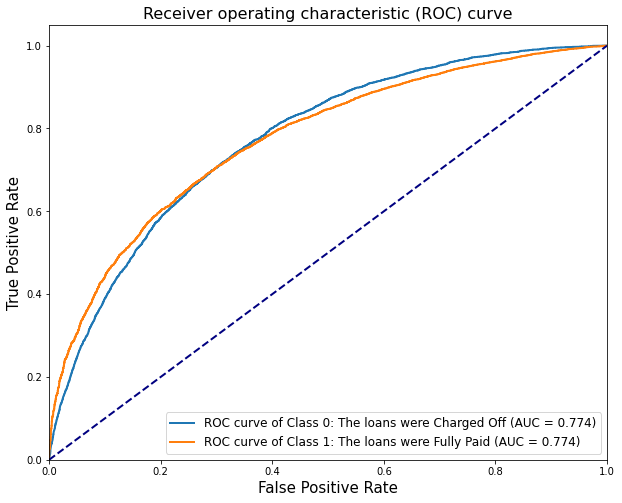

In [85]:
import numpy as np

prob = model.predict(X_test)
full_prob = np.zeros((y_test.shape[0],2))
full_prob[:,0] = 1-np.squeeze(prob)
full_prob[:,1] = np.squeeze(prob)

y_test_array = np.asarray(y_test)
y_test_ar = np.zeros((y_test.shape[0],2))
for i in range(0, y_test.shape[0]):
  if y_test_array[i] == 0:
    y_test_ar[i,0] = 1
  else:
    y_test_ar[i,1] = 1
    
    
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = ["0: The loans were Charged Off", "1: The loans were Fully Paid"]
for i in range(0,2):
    fpr[i], tpr[i], _ = roc_curve(y_test_ar[:, i], full_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,8))
lw = 2
for i in range(2):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of Class {0} (AUC = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic (ROC) curve',fontsize=16)
plt.legend(loc="lower right",fontsize=12)
plt.show()

In [103]:
#serializing our model and saving to disk in order to load into our application later on
model.save('model.h5')

In [137]:
predictions_nn = model.predict_classes(X_test)
roc_auc_score(y_test, predictions_nn)

0.883799839809199

In [173]:
machine_learning_results = pd.DataFrame({'Model':['Logistic Regression','Linear Discriminant Analysis','Quadratic Discriminant Analysis',
    'Multinomial Naive Bayes','Gaussian Naive Bayes','Gradient Boosting Classifier','Random Forest Classifier','Catboost Classifier','MLP Neural Net'],
    'Non-2018 test data AUC score':[0.583, 0.830, 0.616, 0.557, 0.791, 0.831, 0.769, 0.892, 0.884], 
    '2018 test data AUC score':[0.563, 0.756, 0.641, 0.548, 0.756, 0.766, 0.697, 0.841, 0.816]})
machine_learning_results

,Model,Non-2018 test data AUC score,2018 test data AUC score
0,Logistic Regression,0.583,0.563
1,Linear Discriminant Analysis,0.830,0.756
2,Quadratic Discriminant Analysis,0.616,0.641
3,Multinomial Naive Bayes,0.557,0.548
4,Gaussian Naive Bayes,0.791,0.756
5,Gradient Boosting Classifier,0.831,0.766
6,Random Forest Classifier,0.769,0.697
7,Catboost Classifier,0.892,0.841
8,MLP Neural Net,0.884,0.816


In [174]:
machine_learning_results.to_dict('records')

[{'Model': 'Logistic Regression',
  'Non-2018 test data AUC score': 0.583,
  '2018 test data AUC score': 0.563},
 {'Model': 'Linear Discriminant Analysis',
  'Non-2018 test data AUC score': 0.83,
  '2018 test data AUC score': 0.756},
 {'Model': 'Quadratic Discriminant Analysis',
  'Non-2018 test data AUC score': 0.616,
  '2018 test data AUC score': 0.641},
 {'Model': 'Multinomial Naive Bayes',
  'Non-2018 test data AUC score': 0.557,
  '2018 test data AUC score': 0.548},
 {'Model': 'Gaussian Naive Bayes',
  'Non-2018 test data AUC score': 0.791,
  '2018 test data AUC score': 0.756},
 {'Model': 'Gradient Boosting Classifier',
  'Non-2018 test data AUC score': 0.831,
  '2018 test data AUC score': 0.766},
 {'Model': 'Random Forest Classifier',
  'Non-2018 test data AUC score': 0.769,
  '2018 test data AUC score': 0.697},
 {'Model': 'Catboost Classifier',
  'Non-2018 test data AUC score': 0.892,
  '2018 test data AUC score': 0.841},
 {'Model': 'MLP Neural Net',
  'Non-2018 test data AUC sc

In [171]:
#predicting 2018 data using neural net model 

predictions_nn2 = model.predict_classes(X_train_2018)
roc_auc_score(test_target, predictions_nn2)

0.8155649094337568

In [118]:
#model predictions

model.predict(X_test.loc[323571:323571,:])[0][0]

0.967451

In [175]:
#outputting confusion matrix for neural net 

cm_nn = confusion_matrix(test_target, predictions_nn2)

In [176]:
cm_nn

array([[ 11764,   5934],
       [ 16035, 461509]])

In [177]:
accepted_df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_d_date,Year,earliest_cr_line_date,earliest_credit_line_years
0,3600.0,36,13.99,123.03,C4,11.0,MORTGAGE,55000.0,Not Verified,1,...,0.0,0.0,178050.0,2400.0,13734.0,Cash,2015-12-15,2015,2003-08-15,4505 days
1,24700.0,36,11.99,820.28,C1,11.0,MORTGAGE,65000.0,Not Verified,1,...,0.0,0.0,314017.0,79300.0,24667.0,Cash,2015-12-15,2015,1999-12-15,5844 days
2,20000.0,60,10.78,432.66,B4,11.0,MORTGAGE,63000.0,Not Verified,1,...,0.0,0.0,218418.0,6200.0,14877.0,Cash,2015-12-15,2015,2000-08-15,5600 days
3,35000.0,60,14.85,829.90,C5,11.0,MORTGAGE,110000.0,Source Verified,1,...,0.0,0.0,381215.0,62500.0,18000.0,Cash,2015-12-15,2015,2008-09-15,2647 days
4,10400.0,60,22.45,289.91,F1,3.0,MORTGAGE,104433.0,Source Verified,1,...,0.0,0.0,439570.0,20300.0,88097.0,Cash,2015-12-15,2015,1998-06-15,6392 days


In [ ]:
print_full()

In [184]:
x_train_lg.columns[:70]

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
       'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m'

In [186]:
x_train_lg.columns[70:140]

Index(['sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_busi

In [187]:
x_train_lg.columns[140:]

Index(['addr_state_MI', 'addr_state_MN', 'addr_state_MO', 'addr_state_MS',
       'addr_state_MT', 'addr_state_NC', 'addr_state_ND', 'addr_state_NE',
       'addr_state_NH', 'addr_state_NJ', 'addr_state_NM', 'addr_state_NV',
       'addr_state_NY', 'addr_state_OH', 'addr_state_OK', 'addr_state_OR',
       'addr_state_PA', 'addr_state_RI', 'addr_state_SC', 'addr_state_SD',
       'addr_state_TN', 'addr_state_TX', 'addr_state_UT', 'addr_state_VA',
       'addr_state_VT', 'addr_state_WA', 'addr_state_WI', 'addr_state_WV',
       'addr_state_WY', 'initial_list_status_w', 'application_type_Joint',
       'disbursement_method_DirectPay'],
      dtype='object')

In [ ]:
#offer portfolio optimization by purpose, state, home_ownership, sub_grade

In [190]:
newdict = dict(type1 = 'test', yref = 'test2')

In [191]:
newdict

{'type1': 'test', 'yref': 'test2'}

In [46]:
test_data2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_high',
       'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
      

In [49]:
test_data2['True'].mean()

0.9642639356112769

In [50]:
test_data2['Predicted'] = np.where((test_data2['Good_Loan'] > 0.7373737373737), 1, 0)

In [56]:
test_data2.loc[0,'True'] / test_data2.loc[1,'True']

1.0

In [62]:
test_data2['True'].value_counts()[0] / test_data2['True'].value_counts()[1]

0.037060459350342585

In [63]:
test_data2['Predicted'].value_counts()[0] / test_data2['Predicted'].value_counts()[1]

0.10529546068298432

In [66]:
test_data2['Profit'] = np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 0), test_data2['loan_amnt'] * -1,
                             np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 1),
                                     test_data2['installment'] * test_data2['term'],0))

In [67]:
test_data2['Profit'].sum()

8914328811.44

In [68]:
test_data2['Total_IRR'] = np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 0), 0,
                             np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 1),
                                     test_data2['xirr'],0))

In [78]:
test_data2['PredictAll1'] = 1

In [ ]:
test_data2['Total_IRR'] = np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 0), 0,
                             np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 1),
                                     test_data2['xirr'],0))

In [ ]:
groupby_term = test_data2.groupby(['term'])['Total_IRR'].agg('mean')
groupby_term = pd.DataFrame(groupby_term)

In [79]:
test_data2['Total_IRR_Dumb_Model'] = np.where((test_data2['PredictAll1'] == 1) & (test_data2['True'] == 0), 0,
                             np.where((test_data2['PredictAll1'] == 1) & (test_data2['True'] == 1),
                                     test_data2['xirr'],0))

In [82]:
groupby_term_dumb = test_data2.groupby(['term'])['Total_IRR_Dumb_Model'].agg('mean')
groupby_term_dumb = pd.DataFrame(groupby_term_dumb)

In [83]:
groupby_term_dumb

,Total_IRR_Dumb_Model
term,
36,0.058941
60,0.096728


In [76]:
groupby_term

,Total_IRR
term,
36,0.073926
60,0.106258


In [86]:
#36-month loans 

#comparing variances of the two groups to see if we can assume equal variance when performing two sample t-test
group1 = test_data2['Total_IRR']
group2 = test_data2['Total_IRR_Dumb_Model']
print(np.var(group2) / np.var(group1))
#since their ratio is <4, we can assume equal variances for our two sample t-test

3.062550742374941


In [87]:
import scipy.stats as stats

stats.ttest_ind(a=group1, b=group2, equal_var=True)

Ttest_indResult(statistic=78.24354390640326, pvalue=0.0)

In [88]:
test_data2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_high',
       'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
      

In [89]:
test_data2.addr_state

0         OK
1         FL
2         NH
3         AL
4         WA
          ..
495237    NV
495238    NJ
495239    CA
495240    NY
495241    FL
Name: addr_state, Length: 495242, dtype: object

In [90]:
with open('test_data2.pickle','wb') as test_data2_file:
     pickle.dump(test_data2, test_data2_file)

In [148]:
test_data2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_high',
       'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
      

In [159]:
test_data3 = test_data2[['home_ownership','purpose','addr_state','loan_amnt','term','int_rate','installment',
                            'True_IRR','xirr']]

In [160]:
test_data3.rename(columns = {'home_ownership':'Home_Ownership_Status','purpose':'Loan_Purpose','addr_state':'State',
                         'loan_amnt':'Loan_Amount','term':'Loan_Term','int_rate':'Loan_Interest_Rate',
                        'installment':'Loan_Installment','Total_IRR':'True_IRR','xirr':'Predicted_IRR'}, inplace = True) 

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [153]:
test_data3.shape

(495242, 9)

In [142]:
test_data3 = test_data3[['Home_Ownership_Status', 'Loan_Purpose','State',
                         'Loan_Amount','Loan_Term','Loan_Interest_Rate','Loan_Installment','Predicted_IRR','True_IRR']]

In [127]:
test_data2.rename(columns = {'Predicted_IRR':'xirr','Loan_Installment':'Installment'}, inplace = True)

In [161]:
test_data3 = test_data3.loc[test_data3['Predicted_IRR'] > 0.01]
test_data3 = test_data3.sort_values('Predicted_IRR', ascending = False)
test_data3.head()

,Home_Ownership_Status,Loan_Purpose,State,Loan_Amount,Loan_Term,Loan_Interest_Rate,Loan_Installment,True_IRR,Predicted_IRR
83795,MORTGAGE,home_improvement,OR,5000.0,36,30.65,214.05,0.343795,0.343795
209729,MORTGAGE,debt_consolidation,WI,15125.0,60,30.79,496.71,0.339780,0.339780
117663,MORTGAGE,debt_consolidation,VA,20000.0,60,30.89,658.05,0.339500,0.339500
60413,OWN,credit_card,FL,25000.0,60,30.75,820.39,0.338460,0.338460
396951,MORTGAGE,credit_card,ND,11175.0,60,30.79,367.00,0.338452,0.338452


In [163]:
test_data3 = test_data3.sample(50000)
test_data3.head()

,Home_Ownership_Status,Loan_Purpose,State,Loan_Amount,Loan_Term,Loan_Interest_Rate,Loan_Installment,True_IRR,Predicted_IRR
142267,MORTGAGE,debt_consolidation,MI,16000.0,36,7.21,495.58,0.061175,0.061175
277779,MORTGAGE,other,CA,30000.0,60,10.33,642.30,0.067424,0.067424
151585,MORTGAGE,debt_consolidation,LA,16000.0,60,18.94,414.53,0.182478,0.182478
443663,RENT,debt_consolidation,NY,6600.0,36,20.39,246.60,0.188793,0.188793
422711,MORTGAGE,home_improvement,NJ,10000.0,60,12.13,223.11,0.092407,0.092407


In [164]:
with open('test_data2.pickle','wb') as test_data3_file:
     pickle.dump(test_data3, test_data3_file)

In [94]:
#portfolio optimization section
list(test_data2['addr_state'].unique())

['OK',
 'FL',
 'NH',
 'AL',
 'WA',
 'CA',
 'OR',
 'GA',
 'PA',
 'WI',
 'NY',
 'MD',
 'DC',
 'TX',
 'LA',
 'MN',
 'NC',
 'CO',
 'WV',
 'MA',
 'TN',
 'MO',
 'IL',
 'NJ',
 'AR',
 'WY',
 'CT',
 'IN',
 'KY',
 'AZ',
 'NV',
 'ME',
 'VA',
 'MI',
 'HI',
 'OH',
 'UT',
 'NM',
 'SC',
 'KS',
 'ND',
 'MS',
 'DE',
 'ID',
 'RI',
 'NE',
 'MT',
 'AK',
 'VT',
 'SD']

In [95]:
list(test_data2['home_ownership'].unique())

['RENT', 'OWN', 'MORTGAGE', 'ANY']

In [102]:
purposes = []
for x in list(test_data2['purpose'].unique()):
    purposes.append({'label':x,'value':x})
purposes

[{'label': 'other', 'value': 'other'},
 {'label': 'debt_consolidation', 'value': 'debt_consolidation'},
 {'label': 'medical', 'value': 'medical'},
 {'label': 'major_purchase', 'value': 'major_purchase'},
 {'label': 'home_improvement', 'value': 'home_improvement'},
 {'label': 'credit_card', 'value': 'credit_card'},
 {'label': 'vacation', 'value': 'vacation'},
 {'label': 'house', 'value': 'house'},
 {'label': 'car', 'value': 'car'},
 {'label': 'small_business', 'value': 'small_business'},
 {'label': 'moving', 'value': 'moving'},
 {'label': 'renewable_energy', 'value': 'renewable_energy'},
 {'label': 'wedding', 'value': 'wedding'}]

In [108]:
xf = pd.DataFrame([])
xf.head()

""


In [168]:
accepted_df.loan_status.value_counts()[1] / accepted_df.loan_status.value_counts()[0]

6.681978908725692

In [169]:
np.round(test_data2['xirr'],2)

0        -0.16
1         0.08
2         0.06
3         0.09
4         0.06
          ... 
495237    0.09
495238   -0.73
495239    0.12
495240    0.09
495241    0.05
Name: xirr, Length: 495242, dtype: float64

In [167]:
1 - accepted_df.loan_status.mean()

0.13017479114191977

In [118]:
data.sort_values('xirr', ascending = False)[:10]

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,Good_Loan,True,False_Negative_Cost,ave_non_default,xirr,Predicted,Profit,Total_IRR,PredictAll1,Total_IRR_Dumb_Model
237494,10000.0,36,24.37,394.28,E2,0.0,RENT,30000.0,Source Verified,debt_consolidation,...,0.985510,1,-13988.403048,0.985510,0.259354,1,14194.08,0.259354,1,0.259354
440198,8000.0,36,22.90,309.27,E1,4.0,RENT,30000.0,Verified,debt_consolidation,...,0.990580,1,-11028.843282,0.990580,0.246070,1,11133.72,0.246070,1,0.246070
410260,16500.0,60,26.77,501.57,E5,9.0,RENT,38000.0,Verified,debt_consolidation,...,0.889534,1,-26769.802208,0.889534,0.231090,1,30094.20,0.231090,1,0.231090
223087,20000.0,60,22.35,556.37,D5,8.0,RENT,35000.0,Source Verified,debt_consolidation,...,0.946007,1,-31579.782530,0.946007,0.215504,1,33382.20,0.215504,1,0.215504
105687,15000.0,60,21.45,409.61,D5,11.0,RENT,52000.0,Source Verified,debt_consolidation,...,0.959790,1,-23588.373809,0.959790,0.213192,1,24576.60,0.213192,1,0.213192
177678,29150.0,60,29.69,937.56,F2,11.0,RENT,57000.0,Source Verified,debt_consolidation,...,0.802763,1,-45158.294775,0.802763,0.204776,1,56253.60,0.204776,1,0.204776
206592,8500.0,36,20.89,319.76,D4,11.0,RENT,51000.0,Verified,debt_consolidation,...,0.968208,1,-11145.387814,0.968208,0.201983,1,11511.36,0.201983,1,0.201983
379386,20000.0,60,26.77,607.97,E5,1.0,RENT,34560.0,Not Verified,debt_consolidation,...,0.841072,1,-30680.791817,0.841072,0.199325,1,36478.20,0.199325,1,0.199325
393245,7500.0,36,21.85,285.85,D5,1.0,RENT,42000.0,Verified,debt_consolidation,...,0.952118,1,-9797.863619,0.952118,0.198824,1,10290.60,0.198824,1,0.198824
252619,16000.0,36,19.92,593.97,D3,4.0,RENT,48000.0,Verified,debt_consolidation,...,0.972497,1,-20794.827140,0.972497,0.194450,1,21382.92,0.194450,1,0.194450


In [119]:
datarrr = data[:5]

In [120]:
datarrr[:10]

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,Good_Loan,True,False_Negative_Cost,ave_non_default,xirr,Predicted,Profit,Total_IRR,PredictAll1,Total_IRR_Dumb_Model
159,16000.0,36,6.07,487.26,A2,4.0,RENT,54000.0,Not Verified,debt_consolidation,...,0.986294,1,-17300.939172,0.986294,0.052692,1,17541.36,0.052692,1,0.052692
6494,12000.0,36,10.41,389.53,B3,3.0,RENT,55000.0,Verified,debt_consolidation,...,0.984792,1,-13809.811387,0.984792,0.097719,1,14023.08,0.097719,1,0.097719
6601,35000.0,36,15.04,1213.98,C4,5.0,RENT,36420.0,Source Verified,debt_consolidation,...,0.942267,1,-41180.180140,0.942267,0.114418,1,43703.28,0.114418,1,0.114418
8367,25000.0,60,20.39,667.79,D4,1.0,RENT,54000.0,Source Verified,debt_consolidation,...,0.901708,1,-36129.083660,0.901708,0.167167,1,40067.40,0.167167,1,0.167167
10860,40000.0,60,17.47,1004.24,D1,9.0,RENT,50000.0,Verified,debt_consolidation,...,0.941827,1,-56749.249392,0.941827,0.157553,1,60254.40,0.157553,1,0.157553


In [123]:
test_data2.loc[test_data2['xirr'] > 0].shape

(435581, 86)